# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import researchpy as rp
import re
import featuretools as ft
import joblib
from sklearn.impute import SimpleImputer
from functools import reduce


import mlflow
import mlflow.sklearn
import mlflow.lightgbm
import shap

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc

from preprocessing_pipeline import prepare_input_data, agg_numeric, count_categorical, sanitize_lgbm_colname, predicting_scores

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
EXECUTING THIS VERSION OF preprocessing_pipeline.py - V_DEBUG_001
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [2]:
pd.set_option('display.max_colwidth', None)

push test

# Fonctions

In [3]:
def dataset_overview(df):
    """
    Provides a comprehensive overview of a pandas DataFrame including:
    - Shape of the dataset
    - Column names and data types
    - Missing values
    - Basic statistics for numeric columns
    - Unique values for categorical columns
    """

    print("="*80)
    print("DATASET OVERVIEW")
    print("="*80)

    # Basic info
    print("\nDATASET SHAPE:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("/nCOLUMN INFORMATION:")
    print(df.dtypes.to_string())

    # Missing values
    print("/nMISSING VALUES:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing,
                              'Percentage (%)': missing_percent.round(2)})
    print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage (%)', ascending=False))

    # Numeric columns statistics
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print("/nNUMERIC COLUMNS STATISTICS:")
        print(df[numeric_cols].describe().transpose()[['mean', '50%', 'std', 'min', 'max']]
              .rename(columns={'50%': 'median'}))

    # Categorical columns statistics
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("/nCATEGORICAL COLUMNS STATISTICS:")
        for col in cat_cols:
            print(f"\nColumn: {col}")
            print(f"Unique values: {df[col].nunique()}")
            print("Top 5 values:")
            print(df[col].value_counts().head())

    print("="*80)

In [4]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

## Fonction pour aggrégation valeurs numériques

In [5]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

## Fonction pour aggréger variables catégorielles

In [6]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

# Chargement datasets

In [7]:
HomeCredit_ini = pd.read_csv('data/HomeCredit_columns_description.csv', encoding='latin-1')
POS_CASH_balance_ini = pd.read_csv('data/POS_CASH_balance.csv')
installments_payments_ini = pd.read_csv('data/installments_payments.csv')
previous_application_ini = pd.read_csv('data/previous_application.csv')
application_test_ini = pd.read_csv('data/application_test.csv')
application_train_ini = pd.read_csv('data/application_train.csv')
bureau_balance_ini = pd.read_csv('data/bureau_balance.csv')
bureau_ini = pd.read_csv('data/bureau.csv')
sample_submission_ini = pd.read_csv('data/sample_submission.csv')
credit_card_balance_ini = pd.read_csv('data/credit_card_balance.csv')
features_manual_and_func_from_first_three_with_app_train_ini = pd.read_csv('data/features_manual_and_func_from_first_three_with_app_train.csv')

In [8]:
HomeCredit = HomeCredit_ini.copy()
POS_CASH_balance = POS_CASH_balance_ini.copy()
installments_payments = installments_payments_ini.copy()
previous_application = previous_application_ini.copy()
application_test = application_test_ini.copy()
application_train = application_train_ini.copy()
bureau_balance = bureau_balance_ini.copy()
bureau = bureau_ini.copy()
sample_submission = sample_submission_ini.copy()
credit_card_balance = credit_card_balance_ini.copy()
features_manual_and_func_from_first_three_with_app_train = features_manual_and_func_from_first_three_with_app_train_ini.copy()

# Rappel précédent notebook et étapes à suivre

Au cours du précédent notebook on a pu réaliser plusieurs runs avec LightBGM en utilisant les données des trois premiers datasets qui sont : application_train, bureau et bureau_balance avec des feature créees manuellement, des features créees avec les fonctions d'aggrégation pour les variables numériques et catégorielles et aussi des features créees avec feature tools. Les résultats n'étant pas concluants on va ajouter les données contenues dans les autres datasets. On ne va pas aller autant en détail notamment du à un manque de connaissances métier.

Les étapes à suivre sont les suivantes : - Obtenir les features des autres DataFrames
                                         - Tout regrouper en un seul DataFrame
                                         - Réaliser un test initial avec LightGBM en introduisant de la crossvalidation et réaliser un peu de fine tuning
                                         - Analyser les corrélations et éventuellement retirer les variables trop corréelées entre elles
                                         - Relancer LightBGM
                                         - Analyser la feature importance et voir si l'on peut se débarasser du bruit
                                         - Relancer LightGBM
                                         - Aller plus en détail sur la feature importance
                                         - Si l'on suppose que le coût d'un FN (client ne pouvant pas rembourser le prêt mais prédit comme pouvant le rembourser) est 10 fois plus supérieur à celui d'un FP on peut introduire des poids dans notre modèle
                                         - Relancer LightGBM et analyser/optimiser le seuil de décision
                                         - Plus de fine tuning avec GridSearchCV
                                         - Tout au long de ces analyses comparer les résultats en utilisant ROC AUC et les différentes métriques liées au matrices de confusion

# Preprocessing application_test

In [ ]:
full_data = prepare_input_data(
            application_test, 
            bureau, 
            bureau_balance,
            previous_application, 
            POS_CASH_balance,
            installments_payments, 
            credit_card_balance
        )


Dataset was properly aggregated.


In [ ]:
full_data

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,0,0,1,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48740,456222,0,0,0,0,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,0,0,1,1,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48742,456224,0,1,0,0,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_file_path = 'pipeline_input_columns.txt'
with open(column_file_path, 'r') as f:
    loaded_cols = [line.strip() for line in f if line.strip()]
expected_input_columns = loaded_cols
current_columns = set(full_data.columns)
expected_columns_set = set(expected_input_columns)
columns_to_drop = list(current_columns - expected_columns_set)
columns_to_drop_existing = [col for col in columns_to_drop if col in full_data.columns]
if columns_to_drop_existing:
    full_data.drop(columns=columns_to_drop_existing, inplace=True)
columns_to_add = list(expected_columns_set - set(full_data.columns))
for col in columns_to_add:
    full_data[col] = np.nan

In [ ]:
full_data.shape[1]

261

In [ ]:
X_test_filtered_with_non_null_importance = full_data.copy()

# Overview des DataFrames

Même si on pourrait fusionner certains de ces DataFrames avant on va éviter sinon les aggrégations avec la moyenne par exemple pourraient être faussées/introduction de biais

In [ ]:
previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [ ]:
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [ ]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [ ]:
installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


# Aggrégation des DataFrames

## Aggrégation de previous_application

### Overview

In [ ]:
previous_application['SK_ID_PREV'].nunique()

1670214

### Aggrégation

In [ ]:
previous_application_num_agg_SK_ID_CURR = agg_numeric(previous_application.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='previous_application')
previous_application_num_agg_SK_ID_CURR

,SK_ID_CURR,previous_application_AMT_ANNUITY_count,previous_application_AMT_ANNUITY_mean,previous_application_AMT_ANNUITY_max,previous_application_AMT_ANNUITY_min,previous_application_AMT_ANNUITY_sum,previous_application_AMT_APPLICATION_count,previous_application_AMT_APPLICATION_mean,previous_application_AMT_APPLICATION_max,previous_application_AMT_APPLICATION_min,...,previous_application_DAYS_TERMINATION_count,previous_application_DAYS_TERMINATION_mean,previous_application_DAYS_TERMINATION_max,previous_application_DAYS_TERMINATION_min,previous_application_DAYS_TERMINATION_sum,previous_application_NFLAG_INSURED_ON_APPROVAL_count,previous_application_NFLAG_INSURED_ON_APPROVAL_mean,previous_application_NFLAG_INSURED_ON_APPROVAL_max,previous_application_NFLAG_INSURED_ON_APPROVAL_min,previous_application_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000,3951.000,3951.000,1,24835.500,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775000,9251.775,9251.775,9251.775,1,179055.000,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.990000,98356.995,6737.310,169661.970,3,435436.500,900000.0,68809.5,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250,5357.250,5357.250,1,24282.000,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200000,4813.200,4813.200,4813.200,2,22308.750,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,1,6605.910000,6605.910,6605.910,6605.910,1,40455.000,40455.0,40455.0,...,1,-25.000000,-25.0,-25.0,-25.0,1,0.000000,0.0,0.0,0.0
338853,456252,1,10074.465000,10074.465,10074.465,10074.465,1,57595.500,57595.5,57595.5,...,1,-2311.000000,-2311.0,-2311.0,-2311.0,1,1.000000,1.0,1.0,1.0
338854,456253,2,4770.405000,5567.715,3973.095,9540.810,2,24162.750,28912.5,19413.0,...,2,-2212.500000,-1712.0,-2713.0,-4425.0,2,0.500000,1.0,0.0,1.0
338855,456254,2,10681.132500,19065.825,2296.440,21362.265,2,121317.750,223789.5,18846.0,...,2,365243.000000,365243.0,365243.0,730486.0,2,0.500000,1.0,0.0,1.0


In [ ]:
previous_application_cat_agg_SK_ID_CURR = count_categorical(previous_application.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='previous_application')
previous_application_cat_agg_SK_ID_CURR

,previous_application_NAME_CONTRACT_TYPE_Cash loans_count,previous_application_NAME_CONTRACT_TYPE_Cash loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count,previous_application_NAME_CONTRACT_TYPE_Consumer loans_count_norm,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count,previous_application_NAME_CONTRACT_TYPE_Revolving loans_count_norm,previous_application_NAME_CONTRACT_TYPE_XNA_count,previous_application_NAME_CONTRACT_TYPE_XNA_count_norm,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,previous_application_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,previous_application_PRODUCT_COMBINATION_POS industry without interest_count,previous_application_PRODUCT_COMBINATION_POS industry without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count,previous_application_PRODUCT_COMBINATION_POS mobile with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count,previous_application_PRODUCT_COMBINATION_POS mobile without interest_count_norm,previous_application_PRODUCT_COMBINATION_POS other with interest_count,previous_application_PRODUCT_COMBINATION_POS other with interest_count_norm,previous_application_PRODUCT_COMBINATION_POS others without interest_count,previous_application_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.000,0,0.0,1,1.000000,...,0,0.0,1,1.00,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.000,0,0.0,0,0.000000,...,0,0.0,0,0.00,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.000,0,0.0,1,0.333333,...,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.000,0,0.0,1,1.000000,...,0,0.0,0,0.00,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.000,0,0.0,1,0.500000,...,0,0.0,1,0.50,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,0,0.000000,1,1.000000,0,0.000,0,0.0,0,0.000000,...,0,0.0,1,1.00,0,0.0,0,0.0,0,0.0
456252,0,0.000000,1,1.000000,0,0.000,0,0.0,0,0.000000,...,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0
456253,0,0.000000,2,1.000000,0,0.000,0,0.0,0,0.000000,...,0,0.0,2,1.00,0,0.0,0,0.0,0,0.0


### Feature names

In [ ]:
# previous_application_num_agg_SK_ID_CURR and previous_application_cat_agg_SK_ID_CURR

## Aggrégation de POS_CASH_BALANCE

### Overview

In [ ]:
POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [ ]:
POS_CASH_balance['SK_ID_PREV'].nunique()

936325

In [ ]:
POS_CASH_balance['SK_ID_CURR'].nunique()

337252

In [ ]:
HomeCredit[HomeCredit['Table'] == 'POS_CASH_balance.csv']

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previous credit,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,NaN


### Aggrégation

In [ ]:
POS_CASH_balance_num_agg_SK_ID_CURR = agg_numeric(POS_CASH_balance.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='POS_CASH_balance')
POS_CASH_balance_num_agg_SK_ID_CURR

,SK_ID_CURR,POS_CASH_balance_MONTHS_BALANCE_count,POS_CASH_balance_MONTHS_BALANCE_mean,POS_CASH_balance_MONTHS_BALANCE_max,POS_CASH_balance_MONTHS_BALANCE_min,POS_CASH_balance_MONTHS_BALANCE_sum,POS_CASH_balance_CNT_INSTALMENT_count,POS_CASH_balance_CNT_INSTALMENT_mean,POS_CASH_balance_CNT_INSTALMENT_max,POS_CASH_balance_CNT_INSTALMENT_min,...,POS_CASH_balance_SK_DPD_count,POS_CASH_balance_SK_DPD_mean,POS_CASH_balance_SK_DPD_max,POS_CASH_balance_SK_DPD_min,POS_CASH_balance_SK_DPD_sum,POS_CASH_balance_SK_DPD_DEF_count,POS_CASH_balance_SK_DPD_DEF_mean,POS_CASH_balance_SK_DPD_DEF_max,POS_CASH_balance_SK_DPD_DEF_min,POS_CASH_balance_SK_DPD_DEF_sum
0,100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,...,9,0.777778,7,0,7,9,0.777778,7,0,7
1,100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,...,19,0.000000,0,0,0,19,0.000000,0,0,0
2,100003,28,-43.785714,-18,-77,-1226,28,10.107143,12.0,6.0,...,28,0.000000,0,0,0,28,0.000000,0,0,0
3,100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,...,4,0.000000,0,0,0,4,0.000000,0,0,0
4,100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,...,11,0.000000,0,0,0,11,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,9,-5.000000,-1,-9,-45,8,7.875000,8.0,7.0,...,9,0.000000,0,0,0,9,0.000000,0,0,0
337248,456252,7,-79.000000,-76,-82,-553,7,6.000000,6.0,6.0,...,7,0.000000,0,0,0,7,0.000000,0,0,0
337249,456253,17,-79.235294,-57,-96,-1347,17,6.705882,12.0,4.0,...,17,0.294118,5,0,5,17,0.294118,5,0,5
337250,456254,20,-5.550000,-1,-11,-111,20,14.900000,16.0,14.0,...,20,0.000000,0,0,0,20,0.000000,0,0,0


In [ ]:
POS_CASH_balance_cat_agg_SK_ID_CURR = count_categorical(POS_CASH_balance.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='POS_CASH_balance')
POS_CASH_balance_cat_agg_SK_ID_CURR

,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Active_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Amortized debt_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Approved_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Canceled_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Completed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Demand_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Returned to the store_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count,POS_CASH_balance_NAME_CONTRACT_STATUS_Signed_count_norm,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count,POS_CASH_balance_NAME_CONTRACT_STATUS_XNA_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,7,0.777778,0,0.0,0,0.0,0,0.0,2,0.222222,0,0.0,0,0.0,0,0.000000,0,0.0
100002,19,1.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0
100003,26,0.928571,0,0.0,0,0.0,0,0.0,2,0.071429,0,0.0,0,0.0,0,0.000000,0,0.0
100004,3,0.750000,0,0.0,0,0.0,0,0.0,1,0.250000,0,0.0,0,0.0,0,0.000000,0,0.0
100005,9,0.818182,0,0.0,0,0.0,0,0.0,1,0.090909,0,0.0,0,0.0,1,0.090909,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,7,0.777778,0,0.0,0,0.0,0,0.0,1,0.111111,0,0.0,0,0.0,1,0.111111,0,0.0
456252,6,0.857143,0,0.0,0,0.0,0,0.0,1,0.142857,0,0.0,0,0.0,0,0.000000,0,0.0
456253,15,0.882353,0,0.0,0,0.0,0,0.0,2,0.117647,0,0.0,0,0.0,0,0.000000,0,0.0


### Feature names

In [ ]:
# POS_CASH_balance_num_agg_SK_ID_CURR and POS_CASH_balance_cat_agg_SK_ID_CURR

## Aggrégation de credit_card_balance

### Overview

In [ ]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


### Aggrégation

In [ ]:
credit_card_balance_num_agg_SK_ID_CURR = agg_numeric(credit_card_balance.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='credit_card_balance')
credit_card_balance_num_agg_SK_ID_CURR

,SK_ID_CURR,credit_card_balance_MONTHS_BALANCE_count,credit_card_balance_MONTHS_BALANCE_mean,credit_card_balance_MONTHS_BALANCE_max,credit_card_balance_MONTHS_BALANCE_min,credit_card_balance_MONTHS_BALANCE_sum,credit_card_balance_AMT_BALANCE_count,credit_card_balance_AMT_BALANCE_mean,credit_card_balance_AMT_BALANCE_max,credit_card_balance_AMT_BALANCE_min,...,credit_card_balance_SK_DPD_count,credit_card_balance_SK_DPD_mean,credit_card_balance_SK_DPD_max,credit_card_balance_SK_DPD_min,credit_card_balance_SK_DPD_sum,credit_card_balance_SK_DPD_DEF_count,credit_card_balance_SK_DPD_DEF_mean,credit_card_balance_SK_DPD_DEF_max,credit_card_balance_SK_DPD_DEF_min,credit_card_balance_SK_DPD_DEF_sum
0,100006,6,-3.5,-1,-6,-21,6,0.000000,0.000,0.000,...,6,0.000000,0,0,0,6,0.000000,0,0,0
1,100011,74,-38.5,-2,-75,-2849,74,54482.111149,189000.000,0.000,...,74,0.000000,0,0,0,74,0.000000,0,0,0
2,100013,96,-48.5,-1,-96,-4656,96,18159.919219,161420.220,0.000,...,96,0.010417,1,0,1,96,0.010417,1,0,1
3,100021,17,-10.0,-2,-18,-170,17,0.000000,0.000,0.000,...,17,0.000000,0,0,0,17,0.000000,0,0,0
4,100023,8,-7.5,-4,-11,-60,8,0.000000,0.000,0.000,...,8,0.000000,0,0,0,8,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,41,-21.0,-1,-41,-861,41,131834.730732,453627.675,0.000,...,41,0.000000,0,0,0,41,0.000000,0,0,0
103554,456246,8,-5.5,-2,-9,-44,8,13136.731875,43490.115,0.000,...,8,0.000000,0,0,0,8,0.000000,0,0,0
103555,456247,95,-49.0,-2,-96,-4655,95,23216.396211,190202.130,0.000,...,95,0.031579,1,0,3,95,0.021053,1,0,2
103556,456248,23,-13.0,-2,-24,-299,23,0.000000,0.000,0.000,...,23,0.000000,0,0,0,23,0.000000,0,0,0


In [ ]:
credit_card_balance_cat_agg_SK_ID_CURR = count_categorical(credit_card_balance.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='credit_card_balance')
credit_card_balance_cat_agg_SK_ID_CURR

,credit_card_balance_NAME_CONTRACT_STATUS_Active_count,credit_card_balance_NAME_CONTRACT_STATUS_Active_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count,credit_card_balance_NAME_CONTRACT_STATUS_Approved_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
SK_ID_CURR,,,,,,,,,,,,,,
100006,6,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
100011,74,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
100013,96,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
100021,7,0.411765,0,0.0,10,0.588235,0,0.0,0,0.0,0,0.0,0,0.0
100023,8,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,36,0.878049,0,0.0,5,0.121951,0,0.0,0,0.0,0,0.0,0,0.0
456246,8,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0
456247,95,1.000000,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0


### Feature names

In [ ]:
# credit_card_balance_num_agg_SK_ID_CURR and credit_card_balance_cat_agg_SK_ID_CURR

## Aggrégation de installments_payments

### Overview

In [ ]:
installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


### Aggrégation

In [ ]:
installments_payments_num_agg_SK_ID_CURR = agg_numeric(installments_payments.drop(columns=['SK_ID_PREV']), group_var='SK_ID_CURR', df_name='credit_card_balance')
installments_payments_num_agg_SK_ID_CURR

,SK_ID_CURR,credit_card_balance_NUM_INSTALMENT_VERSION_count,credit_card_balance_NUM_INSTALMENT_VERSION_mean,credit_card_balance_NUM_INSTALMENT_VERSION_max,credit_card_balance_NUM_INSTALMENT_VERSION_min,credit_card_balance_NUM_INSTALMENT_VERSION_sum,credit_card_balance_NUM_INSTALMENT_NUMBER_count,credit_card_balance_NUM_INSTALMENT_NUMBER_mean,credit_card_balance_NUM_INSTALMENT_NUMBER_max,credit_card_balance_NUM_INSTALMENT_NUMBER_min,...,credit_card_balance_AMT_INSTALMENT_count,credit_card_balance_AMT_INSTALMENT_mean,credit_card_balance_AMT_INSTALMENT_max,credit_card_balance_AMT_INSTALMENT_min,credit_card_balance_AMT_INSTALMENT_sum,credit_card_balance_AMT_PAYMENT_count,credit_card_balance_AMT_PAYMENT_mean,credit_card_balance_AMT_PAYMENT_max,credit_card_balance_AMT_PAYMENT_min,credit_card_balance_AMT_PAYMENT_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,7,5885.132143,17397.900,3951.000,41195.925,7,5885.132143,17397.900,3951.000,41195.925
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,19,11559.247105,53093.745,9251.775,219625.695,19,11559.247105,53093.745,9251.775,219625.695
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,25,64754.586000,560835.360,6662.970,1618864.650,25,64754.586000,560835.360,6662.970,1618864.650
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,3,7096.155000,10573.965,5357.250,21288.465,3,7096.155000,10573.965,5357.250,21288.465
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,9,6240.205000,17656.245,4813.200,56161.845,9,6240.205000,17656.245,4813.200,56161.845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,7,1.142857,2.0,1.0,8.0,7,4.000000,7,1,...,7,7492.924286,12815.010,6605.910,52450.470,7,7492.924286,12815.010,6605.910,52450.470
339583,456252,6,1.000000,1.0,1.0,6.0,6,3.500000,6,1,...,6,10069.867500,10074.465,10046.880,60419.205,6,10069.867500,10074.465,10046.880,60419.205
339584,456253,14,1.000000,1.0,1.0,14.0,14,4.785714,12,1,...,14,4399.707857,5575.185,2754.450,61595.910,14,4115.915357,5575.185,27.270,57622.815
339585,456254,19,1.000000,1.0,1.0,19.0,19,5.263158,10,1,...,19,10239.832895,19065.825,2296.440,194556.825,19,10239.832895,19065.825,2296.440,194556.825


### Feature names

In [ ]:
# installments_payments_num_agg_SK_ID_CURR

## Merge des DataFrames

Le plus long est installments_payments_num_agg_SK_ID_CURR et étant donné que l'on va réaliser des merge left on va commencer par celui ci pour ne pas perdre de données.

## Liste DataFrames à merge

In [ ]:
dfs_to_merge = [installments_payments_num_agg_SK_ID_CURR, 
                previous_application_num_agg_SK_ID_CURR, previous_application_cat_agg_SK_ID_CURR, 
                POS_CASH_balance_num_agg_SK_ID_CURR, POS_CASH_balance_cat_agg_SK_ID_CURR, 
                credit_card_balance_num_agg_SK_ID_CURR, credit_card_balance_cat_agg_SK_ID_CURR]

In [ ]:
merge_key = 'SK_ID_CURR'

merge_function = lambda left_df, right_df: pd.merge(left_df, right_df, on=merge_key, how='left')
features_func_from_last_four = reduce(merge_function, dfs_to_merge)

print(features_func_from_last_four.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339587 entries, 0 to 339586
Columns: 569 entries, SK_ID_CURR to credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
dtypes: float64(559), int64(10)
memory usage: 1.4 GB
None


In [ ]:
features_func_from_last_four

,SK_ID_CURR,credit_card_balance_NUM_INSTALMENT_VERSION_count,credit_card_balance_NUM_INSTALMENT_VERSION_mean,credit_card_balance_NUM_INSTALMENT_VERSION_max,credit_card_balance_NUM_INSTALMENT_VERSION_min,credit_card_balance_NUM_INSTALMENT_VERSION_sum,credit_card_balance_NUM_INSTALMENT_NUMBER_count,credit_card_balance_NUM_INSTALMENT_NUMBER_mean,credit_card_balance_NUM_INSTALMENT_NUMBER_max,credit_card_balance_NUM_INSTALMENT_NUMBER_min,...,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,7,1.142857,2.0,1.0,8.0,7,4.000000,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339583,456252,6,1.000000,1.0,1.0,6.0,6,3.500000,6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339584,456253,14,1.000000,1.0,1.0,14.0,14,4.785714,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339585,456254,19,1.000000,1.0,1.0,19.0,19,5.263158,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
features_manual_and_func_from_first_three_with_app_train

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_bureau_balance_LOAN_TYPE_Long Term_count,client_bureau_balance_LOAN_TYPE_Long Term_mean,client_bureau_balance_LOAN_TYPE_Long Term_max,client_bureau_balance_LOAN_TYPE_Long Term_min,client_bureau_balance_LOAN_TYPE_Long Term_sum,client_bureau_balance_LOAN_TYPE_Short Term_count,client_bureau_balance_LOAN_TYPE_Short Term_mean,client_bureau_balance_LOAN_TYPE_Short Term_max,client_bureau_balance_LOAN_TYPE_Short Term_min,client_bureau_balance_LOAN_TYPE_Short Term_sum
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,8.0,0.000000,0.0,0.0,0.0,8.0,1.000000,1.0,1.0,8.0
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,4.0,0.000000,0.0,0.0,0.0,4.0,1.000000,1.0,1.0,4.0
307509,307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,1.0,0.000000,0.0,0.0,0.0,1.0,1.000000,1.0,1.0,1.0


In [ ]:
features_manual_and_func_from_first_three_with_app_train.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
pd.merge(left=features_manual_and_func_from_first_three_with_app_train, right=features_func_from_last_four, how='left', on='SK_ID_CURR')

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,0,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,0,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,0,0,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
full_data = pd.merge(left=features_manual_and_func_from_first_three_with_app_train, right=features_func_from_last_four, how='left', on='SK_ID_CURR')
full_data['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

# Création de la fonction pour calculer la variable métier qui va nous permettre de comparer les modèles

On va supposer que le coût d'un FN est 10x supérieur au coût d'un FP

In [ ]:
def calculate_business_cost(y_true, y_pred, cost_fn=10, cost_tn=(-1), cost_fp=1):
    """
    Calculates the total business cost based on a confusion matrix.
    Assumes class 1 is the positive class (default).
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp) + (tn * cost_tn)
    return total_cost

The confusion_matrix returns a 2x2 NumPy array:
[[TN, FP],
 [FN, TP]]

.ravel(): This NumPy method flattens the 2x2 matrix into a 1D array: [TN, FP, FN, TP].
tn, fp, fn, tp = ...: This unpacks the flattened array into individual variables.

# Run LightGBM avec ce nouveau DataFrame

## Sanitization

In [ ]:
# --- Selection features et TARGET 

features_all = [col for col in full_data.columns if col not in ['TARGET', 'SK_ID_CURR']]
X = full_data[features_all]
y = full_data['TARGET']

# --- Split data

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def sanitize_lgbm_colname(colname):
    """More robust sanitization for LightGBM."""
    # Convert to string first
    colname_str = str(colname)
    # Replace common problematic characters (including ., ', etc.) with underscore
    sanitized = re.sub(r'[\[\]{}":\',.<>\s/?!@#$%^&*()+=-]+', '_', colname_str)
    # Replace multiple underscores with single underscore
    sanitized = re.sub(r'_+', '_', sanitized)
    # Remove leading/trailing underscores
    sanitized = sanitized.strip('_')
    # Ensure it's not empty
    if not sanitized:
        sanitized = f"col_{hash(colname_str)}"
    # Ensure it doesn't start with a number (optional, but good practice)
    if sanitized[0].isdigit():
        sanitized = '_' + sanitized
    return sanitized

# --- Apply Sanitization and Alignment ---
print("Sanitizing final X_train and X_val column names...")

# --- Sanitize X_train ---
original_train_cols = X_train.columns.tolist()
new_train_cols = [sanitize_lgbm_colname(col) for col in original_train_cols]

Sanitizing final X_train and X_val column names...


In [ ]:
X_train.columns = new_train_cols
X_val.columns = new_train_cols

In [ ]:
X_train

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count,credit_card_balance_NAME_CONTRACT_STATUS_Completed_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count,credit_card_balance_NAME_CONTRACT_STATUS_Demand_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count,credit_card_balance_NAME_CONTRACT_STATUS_Refused_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Sent_proposal_count,credit_card_balance_NAME_CONTRACT_STATUS_Sent_proposal_count_norm,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count,credit_card_balance_NAME_CONTRACT_STATUS_Signed_count_norm
181648,0,0,0,2,90000.0,227520.0,13189.5,180000.0,0.008230,-12298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229245,0,1,1,0,90000.0,161730.0,13095.0,135000.0,0.003069,-15375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122525,0,0,1,0,135000.0,728847.0,26307.0,553500.0,0.020713,-19307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306311,0,0,0,0,135000.0,474183.0,34636.5,391500.0,0.011703,-17791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300658,0,0,1,0,180000.0,254700.0,27558.0,225000.0,0.006629,-8486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31304,1,0,1,1,135000.0,405000.0,20250.0,405000.0,0.035792,-15374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121193,0,0,0,0,157500.0,272520.0,21528.0,225000.0,0.018801,-19035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248504,0,0,0,0,90000.0,246357.0,24493.5,234000.0,0.025164,-23088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175469,0,0,1,0,112500.0,810000.0,26901.0,810000.0,0.018209,-22148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="First Run with full data and business cost"): #Utile plus tard pour fine tuning
    
    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight='balanced', # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    business_cost = calculate_business_cost(y_val, y_pred, cost_fn=10, cost_tn=(-1), cost_fp=1)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("business_cost", business_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {business_cost}")
    print(classification_report(y_val, y_pred))"""

'# --- MLflow Experiment Run ---\nmlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="First Run with full data and business cost"): #Utile plus tard pour fine tuning\n    \n    # --- Define Model & Pipeline ---\n    pipeline_lgbm = make_pipeline(\n        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg\n        lgb.LGBMClassifier(\n            \n        # --- Core Speed Parameters ---\n        n_estimators=2000,         # number of trees. Default is 100.\n        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu\'on va mettre dans le .fit()\n        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).\n        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but 

In [ ]:
#fitted_lgbm.best_iteration_

In [ ]:
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=pipeline_lgbm.classes_)
#disp.plot()

# Dummy Classifier

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_val)
y_proba_dummy = dummy_clf.predict_proba(X_val)[:, 1] # Probabilities for class 1
print("--- Dummy Classifier Results ---")
print(classification_report(y_val, y_pred_dummy))
print(f"Dummy Classifier ROC AUC: {roc_auc_score(y_val, y_proba_dummy):.4f}")

--- Dummy Classifier Results ---
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     56538
           1       0.08      0.08      0.08      4965

    accuracy                           0.85     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.85      0.85     61503

Dummy Classifier ROC AUC: 0.5016


# Run LightGBM avec optimisation du threshold

In [ ]:
"""# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Second Run with full data and business cost and threshold optimization"): #Utile plus tard pour fine tuning
    
    # --- Define Model & Pipeline ---
    pipeline_lgbm = make_pipeline(
        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg
        lgb.LGBMClassifier(
            
        # --- Core Speed Parameters ---
        n_estimators=2000,         # number of trees. Default is 100.
        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu'on va mettre dans le .fit()
        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).
        max_depth=-1,            # Default (-1 means no limit). You could limit (e.g., 5 or 7) for speed, but num_leaves often controls complexity better.

        # --- Subsampling Parameters (can significantly speed up) ---
        subsample=0.9,           # Use only 70% of data rows per tree. Default is 1.0.
        colsample_bytree=0.9,    # Use only 70% of features per tree. Default is 1.0.
        # subsample_freq=1,      # How often to subsample (every 1 iteration here). Default is 0 (disabled), set to >0 to enable row subsampling.

        # --- Regularization parameters help prevent overfitting

        reg_alpha=0.1,            # Added small L1 regularization
        reg_lambda=0.1,           # Added small L2 regularization

        # --- Other Important Parameters ---
        class_weight='balanced', # Keep this for imbalance.
        random_state=42,
        n_jobs=-1,               # Use all available CPU cores. Default.
        # objective='binary',    # Default for classifier, no need to set usually.
        # metric='auc',          # Default is usually logloss/binary_logloss. AUC is good for evaluation.
        )
    )
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs


    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)
    
    # --- key LGBM params ---
    mlflow.log_param("lgbm_n_estimators", 2000) 
    mlflow.log_param("lgbm_learning_rate", 0.005)              
    mlflow.log_param("lgbm_num_leaves", 31)       
    mlflow.log_param("lgbm_max_depth", -1) 
    mlflow.log_param("lgbm_subsample", 0.9)
    mlflow.log_param("lgbm_colsample_bytree", 0.9)  
    mlflow.log_param("lgbm_n_jobs", -1)
    mlflow.log_param("reg_alpha", 0.1)
    mlflow.log_param("reg_lambda", 0.1) 

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 50 rounds, print every 100 rounds

    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.

    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]

    # --- Train model ---
    pipeline_lgbm.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric='auc',  # <--- Specify AUC here
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm.predict(X_val)
    y_proba = pipeline_lgbm.predict_proba(X_val)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))"""

'# --- MLflow Experiment Run ---\nmlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="Second Run with full data and business cost and threshold optimization"): #Utile plus tard pour fine tuning\n    \n    # --- Define Model & Pipeline ---\n    pipeline_lgbm = make_pipeline(\n        StandardScaler(), # Scaling is still generally recommended for LGBM, though less critical than for LogReg\n        lgb.LGBMClassifier(\n            \n        # --- Core Speed Parameters ---\n        n_estimators=2000,         # number of trees. Default is 100.\n        learning_rate=0.005,       # learning rate of 0.05 with 2000 estimators is a common strategy coupled with early stopping qu\'on va mettre dans le .fit()\n        num_leaves=31,           # LOW number. Default is 31. Fewer leaves = simpler trees = faster. Increase later (e.g., 31, 63).\n        max_depth=-1,            # Default (-1 means no limit). You could limit (e

In [ ]:
#fitted_lgbm.best_iteration_

In [ ]:
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=pipeline_lgbm.classes_)
#disp.plot()

# Run LightGBM avec d'abord GridSearchCV puis optimisation du threshold

In [ ]:
"""
# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Third Run with full data and business cost and GridSearchCV and threshold optimization"): #Utile plus tard pour fine tuning

    # 

    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---
    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")

    # Define pipeline FOR GridSearchCV
    # Note: No n_estimators here if it's in param_grid. Early stopping is not directly used IN grid search here.
    lgbm_for_grid = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=1 #Valeur changée en 1 pour soucis mémorie
    )
    pipeline_for_grid = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbmclassifier', lgbm_for_grid)
    ])

    # Define Parameter Grid
    param_grid = {
        'lgbmclassifier__n_estimators': [100, 250, 400],       # 3 options
        'lgbmclassifier__learning_rate': [0.05, 0.1],          # 2 options
        'lgbmclassifier__num_leaves': [21, 31, 41, 51],        # 4 options
        'lgbmclassifier__reg_alpha': [0.1],                    # 1 option
        'lgbmclassifier__reg_lambda': [0.1],                   # 1 option
    # Let's keep subsampling fixed for now to limit combinations
    # 'lgbmclassifier__subsample': [0.8, 0.9],
    # 'lgbmclassifier__colsample_bytree': [0.8, 0.9]
    }

    mlflow.log_param("gridsearch_param_grid", str(param_grid))

    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster grid search
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs

    # GridSearchCV - scoring with 'roc_auc' to find robust params
    grid_search = GridSearchCV(
        estimator=pipeline_for_grid,
        param_grid=param_grid,
        scoring='roc_auc', # Focus on good probability ranking first
        cv=cv_strategy,
        verbose=2,
        n_jobs=1 # Use multiple cores if possible
    )

    print("Starting GridSearchCV on X_train, y_train...")
    grid_search.fit(X_train, y_train) # GridSearchCV takes X_train and y_train. It internally performs cross-validation (e.g., 3-fold or 5-fold). In our case 3-fold
    # For each combination of parameters in the param_grid: It trains the pipeline on k-1 folds. 
    # It evaluates on the 1 held-out fold using the chosen scoring metric (e.g., ROC AUC, calculated using default 0.5 threshold for predictions within the scorer). It averages the scores for each parameter combination across all folds.
    print("GridSearchCV complete.")

    # outputs us the best parameters it found that we store
    best_params_from_grid = grid_search.best_params_
    best_cv_score_grid = grid_search.best_score_

    mlflow.log_params({f"best_gs_{k}": v for k, v in best_params_from_grid.items()}) # Log best params from gridseach

    # for k, v in best_params_from_grid.items(): This part iterates through each key-value pair in the best_params_from_grid dictionary.
    # In each iteration, k will be the parameter name (e.g., 'lgbmclassifier__n_estimators'). v will be the corresponding best value (e.g., 400).



    mlflow.log_metric("gridsearch_best_cv_roc_auc", best_cv_score_grid)

    # --- IMPORTANT We then use the parameters it found to use with our model and then we will train our model on our data using these parameters ---
    

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 200 rounds, print every 100 rounds    
    
    # Define the validation set for early stopping
    eval_set = [(X_val, y_val)]
   
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)



    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.


    # --- Important --- Etant donné que l'on utilise EarlyStopping on souhaite avoir assez d'itérations pour que EarlyStopping soit pertinent
    # Donc malgré le fait que GridSearchCV nous ait trouvé une valeur pour n_estimators, on vasimplement la remplacer par une valeur élevée pour être sur que EarlyStopping fasse effet

    # 1. Create the base dictionary from GridSearchCV results, stripping prefixes
    
    # In best_params_from_grid which is a dictionnary so we have key value pairs each key so the name of the parameter has the prefix lgbmclassifier__ which we remove for clarity

    final_lgbm_params = {
    key.replace('lgbmclassifier__', ''): value
    for key, value in best_params_from_grid.items()
    }

    # 2. Add/Ensure the fixed base parameters are present because they were not in best_params_from_grid
    #    This will add them if they weren't tuned
    final_lgbm_params['class_weight'] = 'balanced'
    final_lgbm_params['random_state'] = 42
    final_lgbm_params['n_jobs'] = 1 # Changée en 1 pour soucis de mémoire

    # 3. Explicitly set n_estimators to a high value for early stopping.
    #    This will override the n_estimators value that came from GridSearchCV.
    final_lgbm_params['n_estimators'] = 2000


    # --- Define Model & Pipeline ---
    pipeline_lgbm_final = make_pipeline( # Renamed to avoid confusion with grid search pipeline
    StandardScaler(),
    lgb.LGBMClassifier(**final_lgbm_params) # Use the defined parameters ** is for dictionnary unpacking
    )

    mlflow.log_params({f"best_gs_final_{k}": v for k, v in final_lgbm_params.items()}) # Log best params with sligh adjustments

    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---

    print("Training final LGBM model with early stopping...")

    pipeline_lgbm_final.fit(
        X_train, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric=early_stopping_metric,
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    print("Training part done")

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm_final.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm_final.predict(X_val)
    y_proba = pipeline_lgbm_final.predict_proba(X_val)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm_final.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm_final.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm_final.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))
    """

'\n# --- MLflow Experiment Run ---\nmlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="Third Run with full data and business cost and GridSearchCV and threshold optimization"): #Utile plus tard pour fine tuning\n\n    # \n\n    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---\n    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")\n\n    # Define pipeline FOR GridSearchCV\n    # Note: No n_estimators here if it\'s in param_grid. Early stopping is not directly used IN grid search here.\n    lgbm_for_grid = lgb.LGBMClassifier(\n        class_weight=\'balanced\',\n        random_state=42,\n        n_jobs=1 #Valeur changée en 1 pour soucis mémorie\n    )\n    pipeline_for_grid = Pipeline([\n        (\'scaler\', StandardScaler()),\n        (\'lgbmclassifier\', lgbm_for_grid)\n    ])\n\n    # Define Parameter Grid\n    param_grid = {\n        \'lgbmclassifier__n_estimators\': [100, 250, 400

In [ ]:
#fitted_lgbm.best_iteration_

In [ ]:
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              #display_labels=pipeline_lgbm_final.classes_)
#disp.plot()

# Prise en compte de la multicolinéarité des variables

On va désormais supprimer les variables trop corrélées entre elles tout en gardant celle qui est le plus corrélée à la TARGET pour cela on va calculer notre matrice de corrélation en utilisant la méthode Spearman étant donné que l'on à un déséquilibre des classes avec la TARGET et on va utiliser la valeur absolue pour traiter de la même façon les corrélations positives et négatives

In [ ]:
"""
# correlation_threshold_ff: Feature-to-feature correlation threshold (e.g., 0.95)

correlation_threshold_ftf = 0.95

# --- Calculate Spearman correlation of features with the target ---
print("Calculating feature-target correlations (Spearman)...")
target_corr = X_train.corrwith(y_train, method='spearman').abs()
# .abs() because we care about the strength of correlation, not direction, for this selection
# On calcule cette corrélation avec la target pour qu'après quand on regarde les corrélations des variables entre elles on puissse sélectionner celle la plus corrélée à la target

# --- Calculate feature-to-feature Spearman correlation matrix ---
print("\nCalculating feature-to-feature correlation matrix (Spearman)...")
# Ensure only numeric types are used for correlation matrix
numeric_cols_for_corr = X_train.select_dtypes(include=np.number).columns
corr_matrix_ftf = X_train[numeric_cols_for_corr].corr(method='spearman').abs()

# --- Identify and remove highly correlated features ---
print(f"\nIdentifying features to drop with feature-to-feature correlation > {correlation_threshold_ftf}...")
upper_tri = corr_matrix_ftf.where(np.triu(np.ones(corr_matrix_ftf.shape), k=1).astype(bool))

# np.ones crée un array NumPy de la meme shape que corr_matrix_ftf qui est rempli de 1
# np.triu prend l'array crée juste avant et k permet de jouer avec quelles valeurs on veut en fonction de la diagonale de cet array 
# En gros une matrice de corrélation est symétrique en fonction de la diagonale ducoup pour nous calculs on a besoin que de la moitié de ces valeurs ducoup on spécifie soit k=1 pour prendre valeurs au dessus de la diagonale ou k=-1 pour en dessous ou k=0 pour prendre la diagonale
# ça va nous retourner un array de la same shape et vu qu'on à mis k=1 toutes les valeurs au dessus de la diagonale sous égales à 1 et la diagonale en elle meme et en dessous c'est remplacé par des 0
# puis on fait .astype(bool) qui transforme les 1 en True et les 0 en False
# Et après le .where qui vient de pandas prend une condition True/False en entrée. Si on a True prend la valeur originale de corr_matrix_ftf sinon si on a False met un NaN à la place
# L'interet d'avoir fait ça c'est 1 de gagner du temps car on ferait tout les memes calculs deux fois sinon mais aussi car on pourrait avoir des soucis si on essaie par exemple de supprimer une meme colonne deux fois

columns_to_drop = set() # Use a set to avoid dropping the same column multiple times

for column in upper_tri.columns:
    # Find features highly correlated with the current 'column'
    highly_correlated_with_column = upper_tri[upper_tri[column] > correlation_threshold_ftf].index.tolist()

    if highly_correlated_with_column:
        # Group contains the current 'column' and all features highly correlated with it
        correlation_group = [column] + highly_correlated_with_column

        # Get target correlations for this group
        group_target_corrs = target_corr.loc[target_corr.index.isin(correlation_group)]

        if not group_target_corrs.empty:
            # Identify the feature in the group with the highest target correlation
            best_feature_in_group = group_target_corrs.idxmax()

            # Identify features to drop (all in group except the best one)
            for feature_to_check in correlation_group:
                if feature_to_check != best_feature_in_group:
                    columns_to_drop.add(feature_to_check)
        else:
            # If no target correlations found for this group (e.g., all were non-numeric or dropped)
            if len(correlation_group) > 1:
                 columns_to_drop.update(correlation_group[1:])


print(f"\nTotal features to drop based on high correlation and target: {len(columns_to_drop)}")
# print("Features to drop:", list(columns_to_drop)) # Uncomment to see the list

# --- Drop the identified columns from X_train and X_val (and X_test later) ---
X_train_corr_filtered = X_train.drop(columns=list(columns_to_drop), errors='ignore')
X_val_corr_filtered = X_val.drop(columns=list(columns_to_drop), errors='ignore')
# X_test_corr_filtered = X_test.drop(columns=list(columns_to_drop), errors='ignore') # For later

print("\nShapes after correlation filtering:")
print("X_train_corr_filtered:", X_train_corr_filtered.shape)
print("X_val_corr_filtered:", X_val_corr_filtered.shape)
"""

'\n# correlation_threshold_ff: Feature-to-feature correlation threshold (e.g., 0.95)\n\ncorrelation_threshold_ftf = 0.95\n\n# --- Calculate Spearman correlation of features with the target ---\nprint("Calculating feature-target correlations (Spearman)...")\ntarget_corr = X_train.corrwith(y_train, method=\'spearman\').abs()\n# .abs() because we care about the strength of correlation, not direction, for this selection\n# On calcule cette corrélation avec la target pour qu\'après quand on regarde les corrélations des variables entre elles on puissse sélectionner celle la plus corrélée à la target\n\n# --- Calculate feature-to-feature Spearman correlation matrix ---\nprint("\nCalculating feature-to-feature correlation matrix (Spearman)...")\n# Ensure only numeric types are used for correlation matrix\nnumeric_cols_for_corr = X_train.select_dtypes(include=np.number).columns\ncorr_matrix_ftf = X_train[numeric_cols_for_corr].corr(method=\'spearman\').abs()\n\n# --- Identify and remove highly 

In [ ]:
"""
correlation_threshold_ftf = 0.95 # threshold pour sélection de features

# --- Calculate Spearman correlation of features with the target ---
print("Calculating feature-target correlations (Spearman)...")
target_corr = X_train.corrwith(y_train, method='spearman').abs()
# .abs() because we care about the strength of correlation, not direction, for this selection
# On calcule cette corrélation avec la target pour qu'après quand on regarde les corrélations des variables entre elles on puissse sélectionner celle la plus corrélée à la target

# --- Calculate feature-to-feature Spearman correlation matrix ---
print("\nCalculating feature-to-feature correlation matrix (Spearman)...")
# Ensure only numeric types are used for correlation matrix
numeric_cols_for_corr = X_train.select_dtypes(include=np.number).columns
corr_matrix_ftf = X_train[numeric_cols_for_corr].corr(method='spearman').abs()


# --- Identify and remove highly correlated features ---
print(f"\nIdentifying features to drop with feature-to-feature correlation > {correlation_threshold_ftf}...")

# Get a list of all feature names that are in the correlation matrix
all_features_in_corr_matrix = corr_matrix_ftf.columns.tolist()

# Use a set to store columns to drop to automatically handle duplicates
columns_to_drop = set() # Once a set is created, you cannot change its items, but you can remove items and add new items and duplicates are not allowed and will be ignored
# Utiliser un set nous permet de ne pas avoir de soucis avec le fait d'avoir les colonnes en deux fois (étant donné que la corr matrix est symétrique)

# Iterate through each unique pair of features
for i in range(len(all_features_in_corr_matrix)):
    feature_i = all_features_in_corr_matrix[i]

    # If feature_i is already marked to be dropped, skip its comparisons
    if feature_i in columns_to_drop:
        continue

    # --- C'est cette partie la ou on va calculer corrélation entre feature[i] et feature[j] et dé cider si on  supprime ou si on garde et la quelle on supprime

    # Inner loop starts from i + 1 to only consider unique pairs (upper triangle idea) si on commencait à i = j ça ne serviarait a rien car on aurait corr = 1 a chaue fois
    for j in range(i + 1, len(all_features_in_corr_matrix)): # cette partie la va nous permettre d'incrémenter la valeur de j pour check toutes les corrélations entre feature[i] et les autres features
        feature_j = all_features_in_corr_matrix[j]

        # If feature_j is already marked to be dropped, skip this pair
        if feature_j in columns_to_drop:
            continue

        # Check the correlation between feature_i and feature_j
        if corr_matrix_ftf.loc[feature_i, feature_j] > correlation_threshold_ftf:
            # If they are highly correlated, decide which one to drop
            # based on their correlation with the target variable.

            # Get the target correlation for feature_i
            # Use .get(key, default_value) to handle cases where a feature might not be in target_corr
            # (e.g., if target_corr was calculated on a subset, or if a feature name is problematic)
            corr_i_target = target_corr.get(feature_i, 0)

            # Get the target correlation for feature_j
            corr_j_target = target_corr.get(feature_j, 0)

            # Compare their correlations with the target
            # We want to keep the one with the HIGHER absolute correlation to the target
            if corr_i_target >= corr_j_target:
                # Keep feature_i, mark feature_j for dropping
                print(f"  '{feature_j}' (target corr: {corr_j_target:.3f}) is highly correlated with '{feature_i}' (target corr: {corr_i_target:.3f}). Dropping '{feature_j}'.")
                columns_to_drop.add(feature_j)
            else:
                # Keep feature_j, mark feature_i for dropping
                print(f"  '{feature_i}' (target corr: {corr_i_target:.3f}) is highly correlated with '{feature_j}' (target corr: {corr_j_target:.3f}). Dropping '{feature_i}'.")
                columns_to_drop.add(feature_i)
                # If feature_i is dropped, we could 'break' the inner loop for feature_i
                # because its further comparisons are now irrelevant. However, letting it
                # continue and relying on the set 'columns_to_drop' to handle uniqueness
                # is also fine and sometimes simpler to manage.
                # For this more complex logic, if feature_i is dropped, its subsequent pairings
                # are still valid with other features unless those other features are also dropped.
                # The `if feature_i in columns_to_drop:` check at the start of the outer loop
                # handles the case where feature_i itself gets dropped.

print(f"\nTotal unique features to drop: {len(columns_to_drop)}")
if columns_to_drop:
    print("Features to drop:", list(columns_to_drop))

# --- Drop the identified columns from X_train and X_val (and X_test later) ---
X_train_corr_filtered = X_train.drop(columns=list(columns_to_drop), errors='ignore')
X_val_corr_filtered = X_val.drop(columns=list(columns_to_drop), errors='ignore')
# X_test_corr_filtered = X_test.drop(columns=list(columns_to_drop), errors='ignore') # For later

print("\nShapes after correlation filtering:")
print("Original X_train shape:", X_train.shape)
print("X_train_corr_filtered shape:", X_train_corr_filtered.shape)
# ... print shapes for X_val ...
"""

'\ncorrelation_threshold_ftf = 0.95 # threshold pour sélection de features\n\n# --- Calculate Spearman correlation of features with the target ---\nprint("Calculating feature-target correlations (Spearman)...")\ntarget_corr = X_train.corrwith(y_train, method=\'spearman\').abs()\n# .abs() because we care about the strength of correlation, not direction, for this selection\n# On calcule cette corrélation avec la target pour qu\'après quand on regarde les corrélations des variables entre elles on puissse sélectionner celle la plus corrélée à la target\n\n# --- Calculate feature-to-feature Spearman correlation matrix ---\nprint("\nCalculating feature-to-feature correlation matrix (Spearman)...")\n# Ensure only numeric types are used for correlation matrix\nnumeric_cols_for_corr = X_train.select_dtypes(include=np.number).columns\ncorr_matrix_ftf = X_train[numeric_cols_for_corr].corr(method=\'spearman\').abs()\n\n\n# --- Identify and remove highly correlated features ---\nprint(f"\nIdentifyi

In [ ]:
X_train_corr_filtered_ini = pd.read_csv('C:/Users/Maxime/Desktop/CSV COrrelations/X_train_corr_filtered.csv')
X_val_corr_filtered_ini = pd.read_csv('C:/Users/Maxime/Desktop/CSV COrrelations/X_val_corr_filtered.csv')

X_train_corr_filtered = X_train_corr_filtered_ini.drop(columns=['Unnamed: 0'])
X_val_corr_filtered = X_val_corr_filtered_ini.drop(columns=['Unnamed: 0'])

# Run LightGBM avec variables trop corrélées entre elles enlevées

In [ ]:
"""
# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Fourth Run with full data and business cost and GridSearchCV and threshold optimization and high correlations removed"): #Utile plus tard pour fine tuning

    # 

    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---
    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")

    # Define pipeline FOR GridSearchCV
    # Note: No n_estimators here if it's in param_grid. Early stopping is not directly used IN grid search here.
    lgbm_for_grid = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=1 #Valeur changée en 1 pour soucis mémorie
    )
    pipeline_for_grid = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbmclassifier', lgbm_for_grid)
    ])

    # Define Parameter Grid
    param_grid = {
        'lgbmclassifier__n_estimators': [100, 250, 400],       # 3 options
        'lgbmclassifier__learning_rate': [0.05, 0.1],          # 2 options
        'lgbmclassifier__num_leaves': [21, 31, 41, 51],        # 4 options
        'lgbmclassifier__reg_alpha': [0.1],                    # 1 option
        'lgbmclassifier__reg_lambda': [0.1],                   # 1 option
    # Let's keep subsampling fixed for now to limit combinations
    # 'lgbmclassifier__subsample': [0.8, 0.9],
    # 'lgbmclassifier__colsample_bytree': [0.8, 0.9]
    }

    mlflow.log_param("gridsearch_param_grid", str(param_grid))

    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster grid search
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs

    # GridSearchCV - scoring with 'roc_auc' to find robust params
    grid_search = GridSearchCV(
        estimator=pipeline_for_grid,
        param_grid=param_grid,
        scoring='roc_auc', # Focus on good probability ranking first
        cv=cv_strategy,
        verbose=2,
        n_jobs=1 # Use multiple cores if possible
    )

    print("Starting GridSearchCV on X_train, y_train...")
    grid_search.fit(X_train_corr_filtered, y_train) # GridSearchCV takes X_train and y_train. It internally performs cross-validation (e.g., 3-fold or 5-fold). In our case 3-fold
    # For each combination of parameters in the param_grid: It trains the pipeline on k-1 folds. 
    # It evaluates on the 1 held-out fold using the chosen scoring metric (e.g., ROC AUC, calculated using default 0.5 threshold for predictions within the scorer). It averages the scores for each parameter combination across all folds.
    print("GridSearchCV complete.")

    # outputs us the best parameters it found that we store
    best_params_from_grid = grid_search.best_params_
    best_cv_score_grid = grid_search.best_score_

    mlflow.log_params({f"best_gs_{k}": v for k, v in best_params_from_grid.items()}) # Log best params from gridseach

    # for k, v in best_params_from_grid.items(): This part iterates through each key-value pair in the best_params_from_grid dictionary.
    # In each iteration, k will be the parameter name (e.g., 'lgbmclassifier__n_estimators'). v will be the corresponding best value (e.g., 400).



    mlflow.log_metric("gridsearch_best_cv_roc_auc", best_cv_score_grid)

    # --- IMPORTANT We then use the parameters it found to use with our model and then we will train our model on our data using these parameters ---
    

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 200 rounds, print every 100 rounds    
    
    # Define the validation set for early stopping
    eval_set = [(X_val_corr_filtered, y_val)]
   
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)



    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.


    # --- Important --- Etant donné que l'on utilise EarlyStopping on souhaite avoir assez d'itérations pour que EarlyStopping soit pertinent
    # Donc malgré le fait que GridSearchCV nous ait trouvé une valeur pour n_estimators, on vasimplement la remplacer par une valeur élevée pour être sur que EarlyStopping fasse effet

    # 1. Create the base dictionary from GridSearchCV results, stripping prefixes
    
    # In best_params_from_grid which is a dictionnary so we have key value pairs each key so the name of the parameter has the prefix lgbmclassifier__ which we remove for clarity

    final_lgbm_params = {
    key.replace('lgbmclassifier__', ''): value
    for key, value in best_params_from_grid.items()
    }

    # 2. Add/Ensure the fixed base parameters are present because they were not in best_params_from_grid
    #    This will add them if they weren't tuned
    final_lgbm_params['class_weight'] = 'balanced'
    final_lgbm_params['random_state'] = 42
    final_lgbm_params['n_jobs'] = 1 # Changée en 1 pour soucis de mémoire

    # 3. Explicitly set n_estimators to a high value for early stopping.
    #    This will override the n_estimators value that came from GridSearchCV.
    final_lgbm_params['n_estimators'] = 2000


    # --- Define Model & Pipeline ---
    pipeline_lgbm_final = make_pipeline( # Renamed to avoid confusion with grid search pipeline
    StandardScaler(),
    lgb.LGBMClassifier(**final_lgbm_params) # Use the defined parameters ** is for dictionnary unpacking
    )

    mlflow.log_params({f"best_gs_final_{k}": v for k, v in final_lgbm_params.items()}) # Log best params with sligh adjustments

    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---

    print("Training final LGBM model with early stopping...")

    pipeline_lgbm_final.fit(
        X_train_corr_filtered, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric=early_stopping_metric,
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    print("Training part done")

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm_final.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm_final.predict(X_val_corr_filtered)
    y_proba = pipeline_lgbm_final.predict_proba(X_val_corr_filtered)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train_corr_filtered.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm_final.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train_corr_filtered.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm_final.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm_final.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))
    """

'\n# --- MLflow Experiment Run ---\nmlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="Fourth Run with full data and business cost and GridSearchCV and threshold optimization and high correlations removed"): #Utile plus tard pour fine tuning\n\n    # \n\n    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---\n    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")\n\n    # Define pipeline FOR GridSearchCV\n    # Note: No n_estimators here if it\'s in param_grid. Early stopping is not directly used IN grid search here.\n    lgbm_for_grid = lgb.LGBMClassifier(\n        class_weight=\'balanced\',\n        random_state=42,\n        n_jobs=1 #Valeur changée en 1 pour soucis mémorie\n    )\n    pipeline_for_grid = Pipeline([\n        (\'scaler\', StandardScaler()),\n        (\'lgbmclassifier\', lgbm_for_grid)\n    ])\n\n    # Define Parameter Grid\n    param_grid = {\n        \'lgbmclassifier_

# Analyse de la feature importance

Apres avoir testé en enlevant les variables trop corrélées entre elles on se retrouve avec un business cost moins bon en ayant enlevé ces variables on va donc réaliser l'analyse de la feature importance avec le modèle qui garde toutes les variables et on va essayer d'enlever le bruit.

In [ ]:
run_id_to_load = "7e69e332cab3437888b88958c8c24fec" # Correspond au modèle avec toutes les données gridsearchCV et threshold optimization
model_artifact_path = "lightgbm_model" # L'artifact path utilisé

In [ ]:
X_train_features = X_train.copy()

In [ ]:
# --- Load the LightGBM model from MLflow --
print(f"Loading LightGBM model from MLflow run ID: {run_id_to_load}, artifact path: {model_artifact_path}")
loaded_lgbm_model = mlflow.lightgbm.load_model(f"runs:/{run_id_to_load}/{model_artifact_path}")

# --- Get Feature Importances ---
print("\nExtracting feature importances...")
importances = loaded_lgbm_model.feature_importances_

# --- Get Feature Names from the X_train used for THAT run ---
feature_names = X_train_features.columns.tolist()

# --- Création du DataFrames quantifiant l'importance des features
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nTop 20 Feature Importances:")
print(feature_importance_df.head(20))

Loading LightGBM model from MLflow run ID: 7e69e332cab3437888b88958c8c24fec, artifact path: lightgbm_model

Extracting feature importances...

Top 20 Feature Importances:
                                                           feature  importance
30                                                    EXT_SOURCE_1         188
31                                                    EXT_SOURCE_2         164
32                                                    EXT_SOURCE_3         133
5                                                       AMT_CREDIT          94
9                                                       DAYS_BIRTH          84
599                            credit_card_balance_AMT_PAYMENT_min          74
6                                                      AMT_ANNUITY          71
7                                                  AMT_GOODS_PRICE          58
600                            credit_card_balance_AMT_PAYMENT_sum          54
368                                    

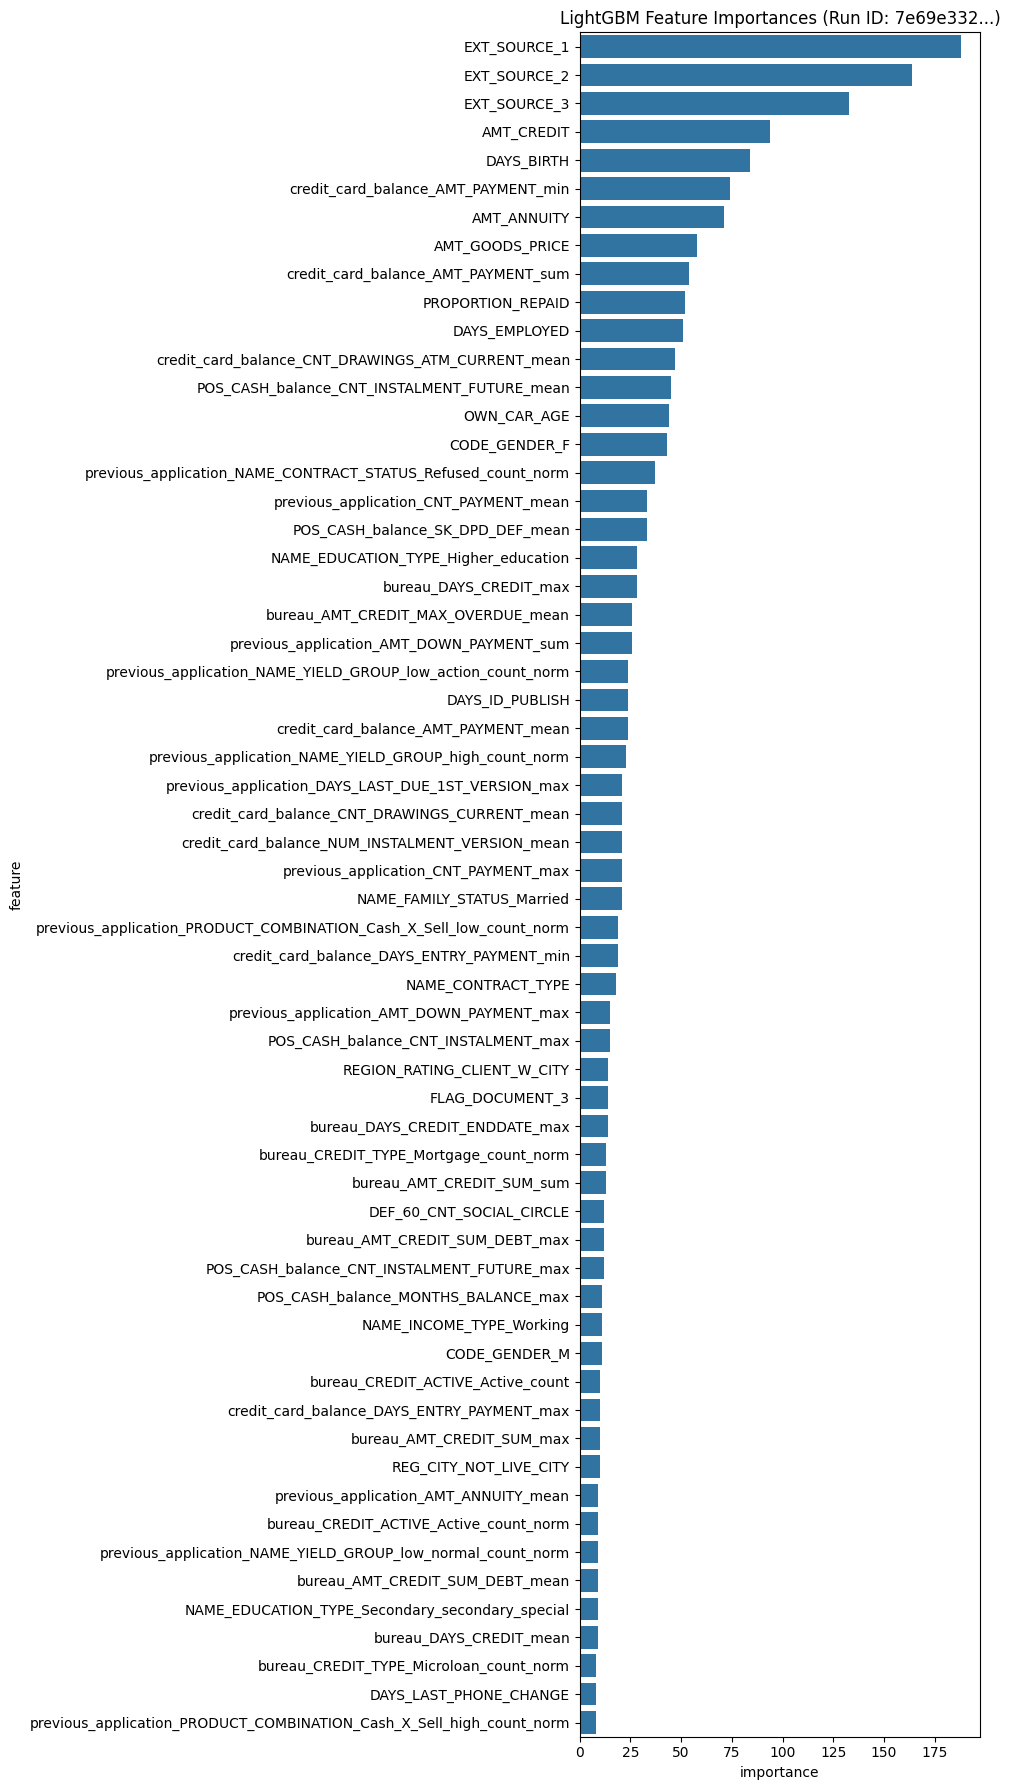

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, max(15, len(feature_importance_df.head(60)) * 0.3))) # Dynamic height
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(60)) # Plot top 60 or fewer
plt.title(f'LightGBM Feature Importances (Run ID: {run_id_to_load[:8]}...)') # Shorten run_id for title
plt.tight_layout()
plt.show()

In [ ]:
zero_importance_features = feature_importance_df[feature_importance_df['importance'] == 0]['feature'].tolist()
print(f"Number of features with ZERO importance: {len(zero_importance_features)}")

Number of features with ZERO importance: 878


On va d'abord supprimer toutes les variables qui ont 0 d'importance.

In [ ]:
# Get the list of features to KEEP
features_to_keep = feature_importance_df[feature_importance_df['importance'] > 0]['feature'].tolist()
print(f"Number of features with NON-ZERO importance to keep: {len(features_to_keep)}")

# Create new DataFrames with only the selected features
# Ensure the X_train/X_val here are the same ones used to train the model whose importances you extracted
X_train_filtered_with_non_null_importance = X_train[features_to_keep]
X_val_filtered_with_non_null_importance = X_val[features_to_keep]
# X_test_fi_filtered = X_test[features_to_keep] # For later

Number of features with NON-ZERO importance to keep: 261


# Run LightGBM avec Features ayant importance nulle filtrées

## Récupération du txt pipeline_input_columns.txt pour docker plus tard

In [ ]:
final_feature_names = X_train_filtered_with_non_null_importance.columns.tolist()
# Save these to pipeline_input_columns.txt
with open('pipeline_input_columns.txt', 'w') as f:
    for col_name in final_feature_names:
        f.write(f"{col_name}\n")
print("pipeline_input_columns.txt has been generated.")

pipeline_input_columns.txt has been generated.


## Baseline Marker

In [ ]:
"""
# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Fifth Run with full data and business cost and GridSearchCV and threshold optimization and 0 importance feature removed"): #Utile plus tard pour fine tuning

    # 

    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---
    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")

    # Define pipeline FOR GridSearchCV
    # Note: No n_estimators here if it's in param_grid. Early stopping is not directly used IN grid search here.
    lgbm_for_grid = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=1 #Valeur changée en 1 pour soucis mémorie
    )
    pipeline_for_grid = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbmclassifier', lgbm_for_grid)
    ])

    # Define Parameter Grid
    param_grid = {
        'lgbmclassifier__n_estimators': [100, 250, 400],       # 3 options
        'lgbmclassifier__learning_rate': [0.05, 0.1],          # 2 options
        'lgbmclassifier__num_leaves': [21, 31, 41, 51],        # 4 options
        'lgbmclassifier__reg_alpha': [0.1],                    # 1 option
        'lgbmclassifier__reg_lambda': [0.1],                   # 1 option
    # Let's keep subsampling fixed for now to limit combinations
    # 'lgbmclassifier__subsample': [0.8, 0.9],
    # 'lgbmclassifier__colsample_bytree': [0.8, 0.9]
    }

    mlflow.log_param("gridsearch_param_grid", str(param_grid))

    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster grid search
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs

    # GridSearchCV - scoring with 'roc_auc' to find robust params
    grid_search = GridSearchCV(
        estimator=pipeline_for_grid,
        param_grid=param_grid,
        scoring='roc_auc', # Focus on good probability ranking first
        cv=cv_strategy,
        verbose=2,
        n_jobs=1 # Use multiple cores if possible
    )

    print("Starting GridSearchCV on X_train, y_train...")
    grid_search.fit(X_train_filtered_with_non_null_importance, y_train) # GridSearchCV takes X_train and y_train. It internally performs cross-validation (e.g., 3-fold or 5-fold). In our case 3-fold
    # For each combination of parameters in the param_grid: It trains the pipeline on k-1 folds. 
    # It evaluates on the 1 held-out fold using the chosen scoring metric (e.g., ROC AUC, calculated using default 0.5 threshold for predictions within the scorer). It averages the scores for each parameter combination across all folds.
    print("GridSearchCV complete.")

    # outputs us the best parameters it found that we store
    best_params_from_grid = grid_search.best_params_
    best_cv_score_grid = grid_search.best_score_

    mlflow.log_params({f"best_gs_{k}": v for k, v in best_params_from_grid.items()}) # Log best params from gridseach

    # for k, v in best_params_from_grid.items(): This part iterates through each key-value pair in the best_params_from_grid dictionary.
    # In each iteration, k will be the parameter name (e.g., 'lgbmclassifier__n_estimators'). v will be the corresponding best value (e.g., 400).



    mlflow.log_metric("gridsearch_best_cv_roc_auc", best_cv_score_grid)

    # --- IMPORTANT We then use the parameters it found to use with our model and then we will train our model on our data using these parameters ---
    

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 200 rounds, print every 100 rounds    
    
    # Define the validation set for early stopping
    eval_set = [(X_val_filtered_with_non_null_importance, y_val)]
   
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)



    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.


    # --- Important --- Etant donné que l'on utilise EarlyStopping on souhaite avoir assez d'itérations pour que EarlyStopping soit pertinent
    # Donc malgré le fait que GridSearchCV nous ait trouvé une valeur pour n_estimators, on vasimplement la remplacer par une valeur élevée pour être sur que EarlyStopping fasse effet

    # 1. Create the base dictionary from GridSearchCV results, stripping prefixes
    
    # In best_params_from_grid which is a dictionnary so we have key value pairs each key so the name of the parameter has the prefix lgbmclassifier__ which we remove for clarity

    final_lgbm_params = {
    key.replace('lgbmclassifier__', ''): value
    for key, value in best_params_from_grid.items()
    }

    # 2. Add/Ensure the fixed base parameters are present because they were not in best_params_from_grid
    #    This will add them if they weren't tuned
    final_lgbm_params['class_weight'] = 'balanced'
    final_lgbm_params['random_state'] = 42
    final_lgbm_params['n_jobs'] = 1 # Changée en 1 pour soucis de mémoire

    # 3. Explicitly set n_estimators to a high value for early stopping.
    #    This will override the n_estimators value that came from GridSearchCV.
    final_lgbm_params['n_estimators'] = 2000


    # --- Define Model & Pipeline ---
    pipeline_lgbm_final = make_pipeline( # Renamed to avoid confusion with grid search pipeline
    StandardScaler(),
    lgb.LGBMClassifier(**final_lgbm_params) # Use the defined parameters ** is for dictionnary unpacking
    )

    mlflow.log_params({f"best_gs_final_{k}": v for k, v in final_lgbm_params.items()}) # Log best params with sligh adjustments

    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---

    print("Training final LGBM model with early stopping...")

    pipeline_lgbm_final.fit(
        X_train_filtered_with_non_null_importance, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric=early_stopping_metric,
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    print("Training part done")

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm_final.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm_final.predict(X_val_filtered_with_non_null_importance)
    y_proba = pipeline_lgbm_final.predict_proba(X_val_filtered_with_non_null_importance)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm_final.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train_filtered_with_non_null_importance.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm_final.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm_final.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))
    """

'\n# --- MLflow Experiment Run ---\nmlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="Fifth Run with full data and business cost and GridSearchCV and threshold optimization and 0 importance feature removed"): #Utile plus tard pour fine tuning\n\n    # \n\n    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---\n    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")\n\n    # Define pipeline FOR GridSearchCV\n    # Note: No n_estimators here if it\'s in param_grid. Early stopping is not directly used IN grid search here.\n    lgbm_for_grid = lgb.LGBMClassifier(\n        class_weight=\'balanced\',\n        random_state=42,\n        n_jobs=1 #Valeur changée en 1 pour soucis mémorie\n    )\n    pipeline_for_grid = Pipeline([\n        (\'scaler\', StandardScaler()),\n        (\'lgbmclassifier\', lgbm_for_grid)\n    ])\n\n    # Define Parameter Grid\n    param_grid = {\n        \'lgbmclassifie

Apres analyse des résultats on peut voir que en enlevant les 878 features ayant une importance = 0 on se retrouve avec des résultats légérements moins bon +1596 de business cost et ROC AUC -0.016 ce qui est assez léger. 
Malgré le fait que nos résultats soient légérement moins bons on va choisir ce nouveau modèle comme notre baseline pour les raisons suivantes :
Il est très probable que sur ces 878 variables que l'on a enlevées même si certaines pouvaient contribuer positivement à la précision du modèle il y a de grandes chances que la majeure partie était en réalité une source de bruit et que le fait que nos résultats soient légérements moins bons soit du au fait que l'on ait supprimé ce bruit.
En enlevant ces variables on se retrouve avec un modèle moins succeptible à l'overfitting car il ne va pas s'entrainer sur ce bruit et sera donc aussi capable de mieux généraliser.
Si l'on souhaite optimiser/fine tune les paramètres avec gridsearch ce sera beaucoup plus simple avec moins de features.
Notre modèle sera aussi plus simple à interpréter.

# Second feature importance analysis after having removed 0 importance features

On va procéder a la suite de l'analyse de feature importance

In [ ]:
#X_train_filtered_with_non_null_importance
#X_val_filtered_with_non_null_importance

In [ ]:
run_id_to_load = "80673ee8f1734525b95cebefc59f17f8" # Correspond au modèle avec toutes les données gridsearchCV et threshold optimization
model_artifact_path = "lightgbm_model" # L'artifact path utilisé

In [ ]:
# --- Load the LightGBM model from MLflow --
print(f"Loading LightGBM model from MLflow run ID: {run_id_to_load}, artifact path: {model_artifact_path}")
loaded_lgbm_model = mlflow.lightgbm.load_model(f"runs:/{run_id_to_load}/{model_artifact_path}")

# --- Get Feature Importances ---
print("\nExtracting feature importances...")
importances = loaded_lgbm_model.feature_importances_

# --- Get Feature Names from the X_train used for THAT run ---
feature_names = X_train_filtered_with_non_null_importance.columns.tolist()

# --- Création du DataFrames quantifiant l'importance des features
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nTop 20 Feature Importances:")
print(feature_importance_df.head(20))

Loading LightGBM model from MLflow run ID: 80673ee8f1734525b95cebefc59f17f8, artifact path: lightgbm_model

Extracting feature importances...

Top 20 Feature Importances:
                                                         feature  importance
0                                                   EXT_SOURCE_1         192
1                                                   EXT_SOURCE_2         157
2                                                   EXT_SOURCE_3         138
4                                                     DAYS_BIRTH          83
5                            credit_card_balance_AMT_PAYMENT_min          76
9                                              PROPORTION_REPAID          58
6                                                    AMT_ANNUITY          44
10                                                 DAYS_EMPLOYED          44
11             credit_card_balance_CNT_DRAWINGS_ATM_CURRENT_mean          44
14                                                 CODE_GEN

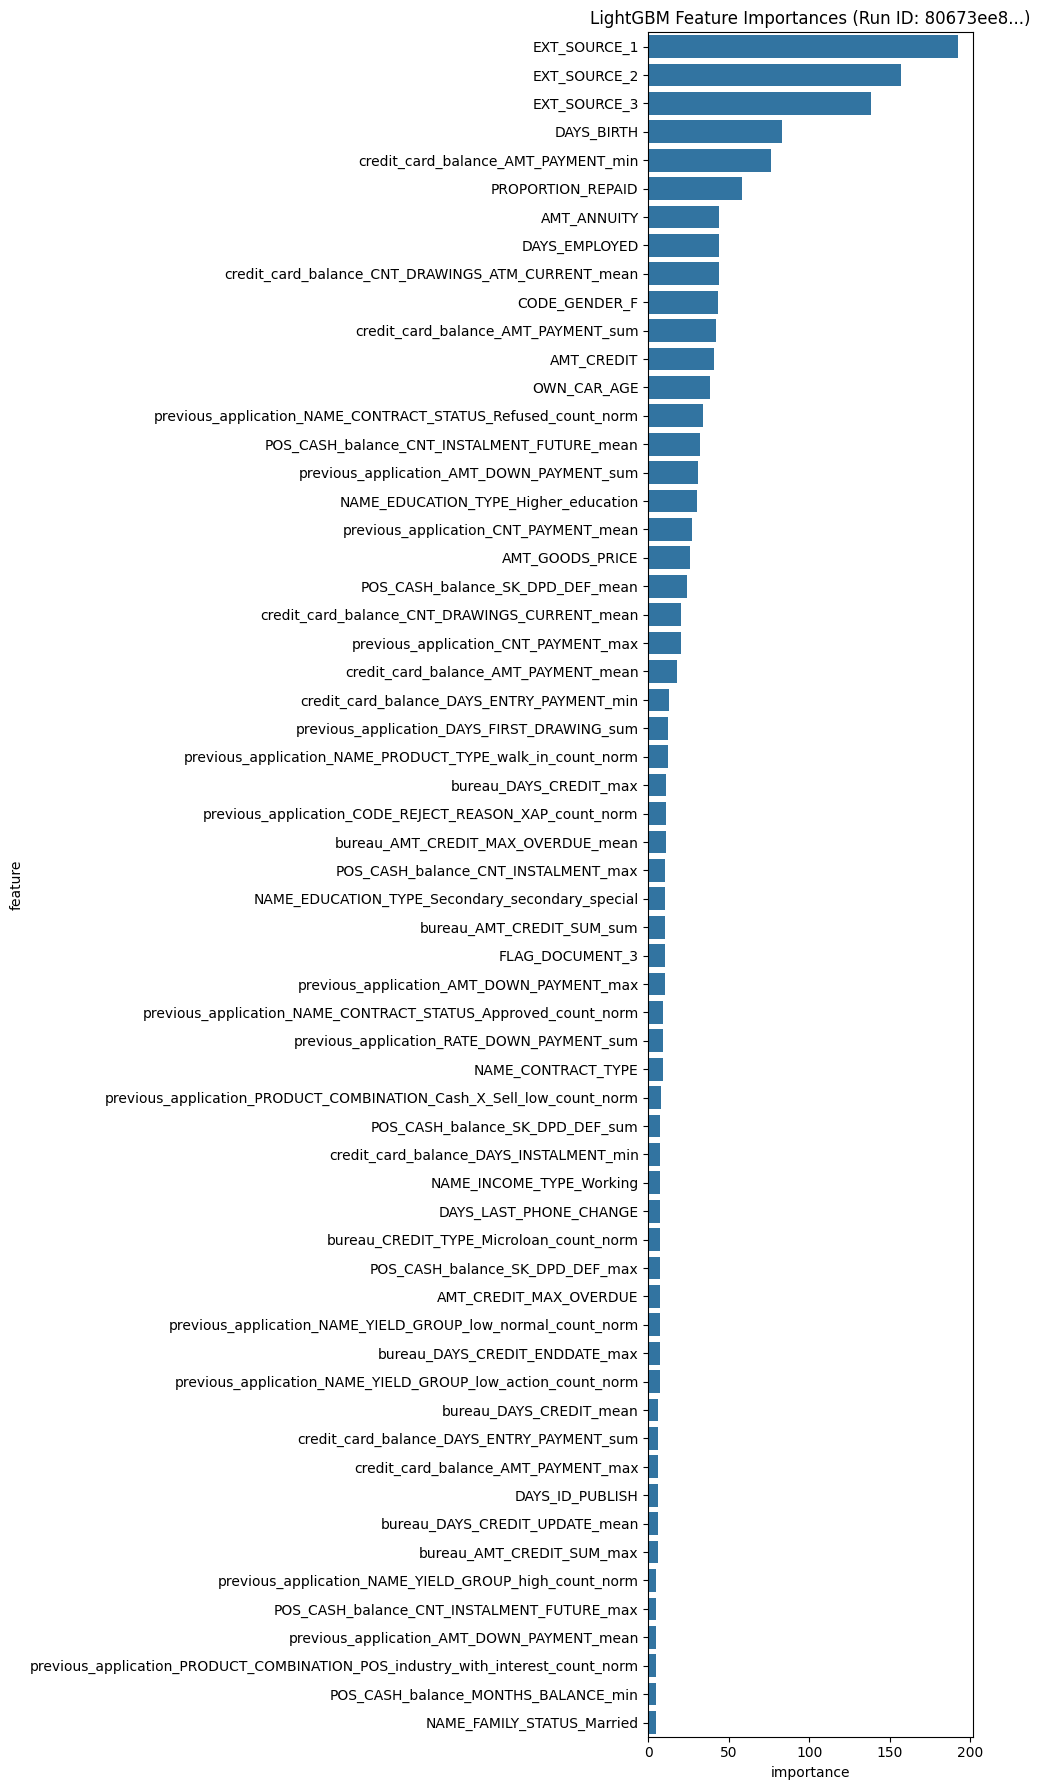

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, max(15, len(feature_importance_df.head(60)) * 0.3))) # Dynamic height
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(60)) # Plot top 60 or fewer
plt.title(f'LightGBM Feature Importances (Run ID: {run_id_to_load[:8]}...)') # Shorten run_id for title
plt.tight_layout()
plt.show()

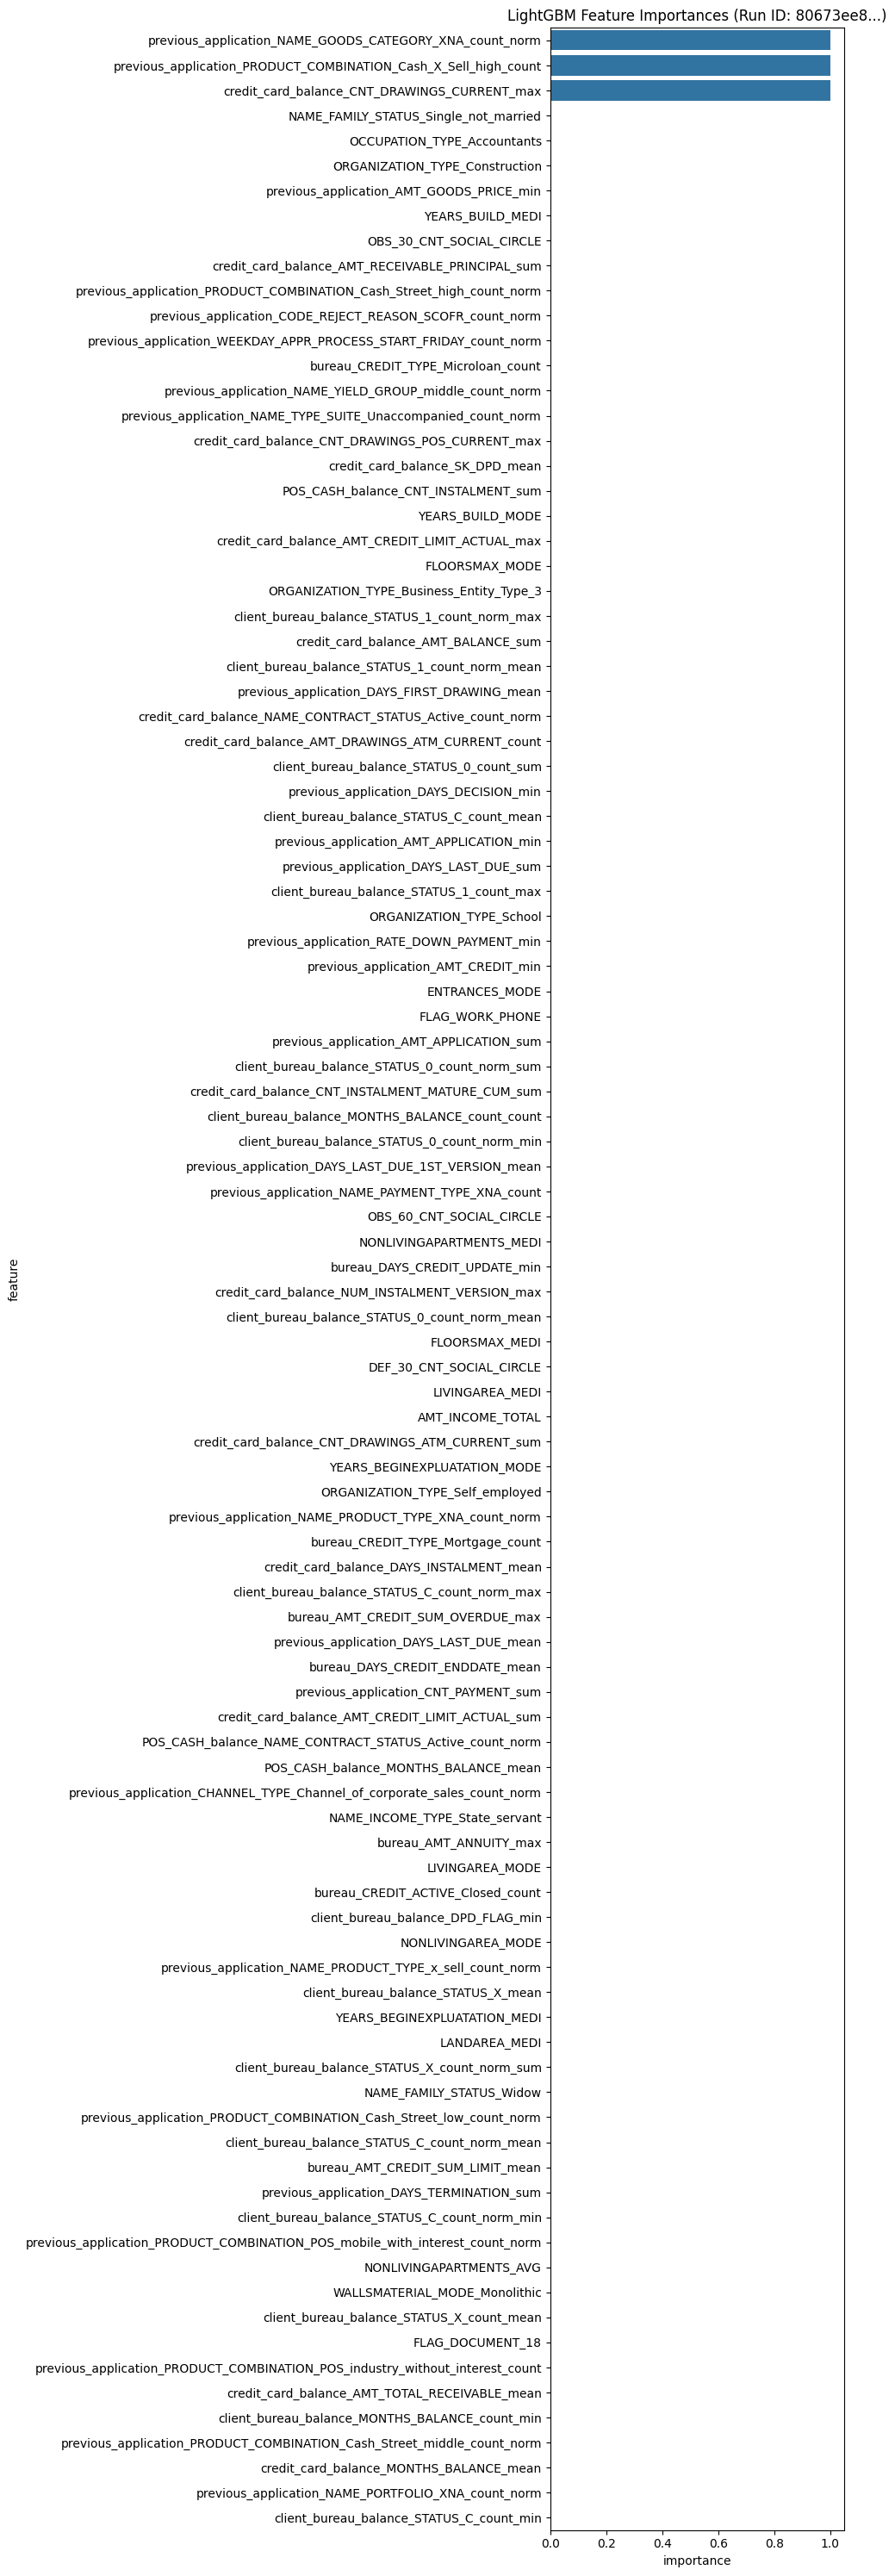

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, max(15, len(feature_importance_df.tail(100)) * 0.3))) # Dynamic height
sns.barplot(x='importance', y='feature', data=feature_importance_df.tail(100)) # Plot top 60 or fewer
plt.title(f'LightGBM Feature Importances (Run ID: {run_id_to_load[:8]}...)') # Shorten run_id for title
plt.tight_layout()
plt.show()

In [ ]:
zero_importance_features = feature_importance_df[feature_importance_df['importance'] == 0]['feature'].tolist()
print(f"Number of features with ZERO importance: {len(zero_importance_features)}")

Number of features with ZERO importance: 97


Après avoir enlevé les 878 features avec importance == 0 et en réalisant à nouveau une analyse de feature importance on se rend compte que 97 features ont désormais une importance nulle et que nos variables qui étaient jugées "importantes" par l'analyse le sont désormais légérement plus. Ce qui est un résultat cohérent lorsque l'on analyse l'importance de features en effet en enlevant le bruit les features que l'on a gardé vont désormais capturer plus de "variance" et auront une importance plus élevée et l'opposé est également possible étant donné que le score d'importance d'une feature est calculé relativement aux autres. Le but de cette analyse de feature importance est de trouver un set de variables robuste qui capturera le plus d'informations et de minimiser le bruit dans nos données.

In [ ]:
# Get the list of features to KEEP
features_to_keep = feature_importance_df[feature_importance_df['importance'] > 0]['feature'].tolist()
print(f"Number of features with NON-ZERO importance to keep: {len(features_to_keep)}")

# Create new DataFrames with only the selected features
# Ensure the X_train/X_val here are the same ones used to train the model whose importances you extracted
X_train_filtered_with_non_null_importance = X_train[features_to_keep]
X_val_filtered_with_non_null_importance = X_val[features_to_keep]
# X_test_fi_filtered = X_test[features_to_keep] # For later

Number of features with NON-ZERO importance to keep: 164


# Run LightGBM en enlevant à nouveau feature à importance = 0

In [ ]:
"""
# --- MLflow Experiment Run ---
mlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments

with mlflow.start_run(run_name="Sixth Run with full data and business cost and GridSearchCV and threshold optimization and 0 importance feature removed AGAIN"): #Utile plus tard pour fine tuning

    # 

    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---
    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")

    # Define pipeline FOR GridSearchCV
    # Note: No n_estimators here if it's in param_grid. Early stopping is not directly used IN grid search here.
    lgbm_for_grid = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=1 #Valeur changée en 1 pour soucis mémorie
    )
    pipeline_for_grid = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbmclassifier', lgbm_for_grid)
    ])

    # Define Parameter Grid
    param_grid = {
        'lgbmclassifier__n_estimators': [100, 250, 400],       # 3 options
        'lgbmclassifier__learning_rate': [0.05, 0.1],          # 2 options
        'lgbmclassifier__num_leaves': [21, 31, 41, 51],        # 4 options
        'lgbmclassifier__reg_alpha': [0.1],                    # 1 option
        'lgbmclassifier__reg_lambda': [0.1],                   # 1 option
    # Let's keep subsampling fixed for now to limit combinations
    # 'lgbmclassifier__subsample': [0.8, 0.9],
    # 'lgbmclassifier__colsample_bytree': [0.8, 0.9]
    }

    mlflow.log_param("gridsearch_param_grid", str(param_grid))

    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster grid search
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs

    # GridSearchCV - scoring with 'roc_auc' to find robust params
    grid_search = GridSearchCV(
        estimator=pipeline_for_grid,
        param_grid=param_grid,
        scoring='roc_auc', # Focus on good probability ranking first
        cv=cv_strategy,
        verbose=2,
        n_jobs=1 # Use multiple cores if possible
    )

    print("Starting GridSearchCV on X_train, y_train...")
    grid_search.fit(X_train_filtered_with_non_null_importance, y_train) # GridSearchCV takes X_train and y_train. It internally performs cross-validation (e.g., 3-fold or 5-fold). In our case 3-fold
    # For each combination of parameters in the param_grid: It trains the pipeline on k-1 folds. 
    # It evaluates on the 1 held-out fold using the chosen scoring metric (e.g., ROC AUC, calculated using default 0.5 threshold for predictions within the scorer). It averages the scores for each parameter combination across all folds.
    print("GridSearchCV complete.")

    # outputs us the best parameters it found that we store
    best_params_from_grid = grid_search.best_params_
    best_cv_score_grid = grid_search.best_score_

    mlflow.log_params({f"best_gs_{k}": v for k, v in best_params_from_grid.items()}) # Log best params from gridseach

    # for k, v in best_params_from_grid.items(): This part iterates through each key-value pair in the best_params_from_grid dictionary.
    # In each iteration, k will be the parameter name (e.g., 'lgbmclassifier__n_estimators'). v will be the corresponding best value (e.g., 400).



    mlflow.log_metric("gridsearch_best_cv_roc_auc", best_cv_score_grid)

    # --- IMPORTANT We then use the parameters it found to use with our model and then we will train our model on our data using these parameters ---
    

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 200 rounds, print every 100 rounds    
    
    # Define the validation set for early stopping
    eval_set = [(X_val_filtered_with_non_null_importance, y_val)]
   
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)



    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.


    # --- Important --- Etant donné que l'on utilise EarlyStopping on souhaite avoir assez d'itérations pour que EarlyStopping soit pertinent
    # Donc malgré le fait que GridSearchCV nous ait trouvé une valeur pour n_estimators, on vasimplement la remplacer par une valeur élevée pour être sur que EarlyStopping fasse effet

    # 1. Create the base dictionary from GridSearchCV results, stripping prefixes
    
    # In best_params_from_grid which is a dictionnary so we have key value pairs each key so the name of the parameter has the prefix lgbmclassifier__ which we remove for clarity

    final_lgbm_params = {
    key.replace('lgbmclassifier__', ''): value
    for key, value in best_params_from_grid.items()
    }

    # 2. Add/Ensure the fixed base parameters are present because they were not in best_params_from_grid
    #    This will add them if they weren't tuned
    final_lgbm_params['class_weight'] = 'balanced'
    final_lgbm_params['random_state'] = 42
    final_lgbm_params['n_jobs'] = 1 # Changée en 1 pour soucis de mémoire

    # 3. Explicitly set n_estimators to a high value for early stopping.
    #    This will override the n_estimators value that came from GridSearchCV.
    final_lgbm_params['n_estimators'] = 2000


    # --- Define Model & Pipeline ---
    pipeline_lgbm_final = make_pipeline( # Renamed to avoid confusion with grid search pipeline
    StandardScaler(),
    lgb.LGBMClassifier(**final_lgbm_params) # Use the defined parameters ** is for dictionnary unpacking
    )

    mlflow.log_params({f"best_gs_final_{k}": v for k, v in final_lgbm_params.items()}) # Log best params with sligh adjustments

    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---

    print("Training final LGBM model with early stopping...")

    pipeline_lgbm_final.fit(
        X_train_filtered_with_non_null_importance, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric=early_stopping_metric,
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    print("Training part done")

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm_final.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm_final.predict(X_val_filtered_with_non_null_importance)
    y_proba = pipeline_lgbm_final.predict_proba(X_val_filtered_with_non_null_importance)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm_final.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train_filtered_with_non_null_importance.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm_final.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm_final.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))
    """

'\n# --- MLflow Experiment Run ---\nmlflow.set_experiment("business_cost Full Data LightGBM") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="Sixth Run with full data and business cost and GridSearchCV and threshold optimization and 0 importance feature removed AGAIN"): #Utile plus tard pour fine tuning\n\n    # \n\n    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---\n    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")\n\n    # Define pipeline FOR GridSearchCV\n    # Note: No n_estimators here if it\'s in param_grid. Early stopping is not directly used IN grid search here.\n    lgbm_for_grid = lgb.LGBMClassifier(\n        class_weight=\'balanced\',\n        random_state=42,\n        n_jobs=1 #Valeur changée en 1 pour soucis mémorie\n    )\n    pipeline_for_grid = Pipeline([\n        (\'scaler\', StandardScaler()),\n        (\'lgbmclassifier\', lgbm_for_grid)\n    ])\n\n    # Define Parameter Grid\n    param_grid = {\n        \'lgbmcla

On a a nouveau de moins bonnes performances mais dans ce cas la on va prioriser le modèle nous donnant les meilleurs résultats donc celui de la 5eme run.

Les raisons sont les suivantes : Lorsque l'on a initialement enlevé les 878 features qui avaient 0 d'importance il s'agit de la premiere fois que l'on enlevait des varaibles et il y avait de grandes chances qu'il s'agissait majoritairement de bruit en plus de cela entre deux modèle il est plus logique de préférer le modèle ou l'on a enlevé 878 features ce qui représente plus de 2/3 des features meme si l'on a de légérement moins bonnes performances car il s'agit d'un bon trade off et permet de simplifier notre modèle significativement tout en facilitant son analyse ou son fine tuning. Cependant si l'on décide d'enlever a nouveau les features jugées avec 0 d'importance il y'a plus de chances qu'il ne s'agissait pas de bruit mais qu'elles contribuaient de manière très subtile à nos prédictions et qu'en les enlevant ce soit équivalent à "overdoing it" si l'on considère qu'elles nétaient initialement pas reconnues comme ayant une importance nulle sur la première analyse et qu'en les enlevant on a une perte de performance au niveau des résultats. En effet en enlevant les 878 qui représentaient plus de deux tiers des données la baisse de performance était très légère relativement à la quantité de données "trimmed" alors que la on décide d'enlever moins d'un tiers des données et la perte de performance est beaucoup plus élevée relativement aux données trimmed.

# Récupération des données pour fine tuning et SHAP

On va donc récupérer à nouveau le jeu de données ou l'on va enlever 878 features

In [ ]:
run_id_to_load = "7e69e332cab3437888b88958c8c24fec" # Correspond au modèle avec toutes les données gridsearchCV et threshold optimization pour récuperer noms features avant d'enlever celles avec importance nulle
model_artifact_path = "lightgbm_model" # L'artifact path utilisé
X_train_features = X_train.copy()
# --- Load the LightGBM model from MLflow --
print(f"Loading LightGBM model from MLflow run ID: {run_id_to_load}, artifact path: {model_artifact_path}")
loaded_lgbm_model = mlflow.lightgbm.load_model(f"runs:/{run_id_to_load}/{model_artifact_path}")

# --- Get Feature Importances ---
print("\nExtracting feature importances...")
importances = loaded_lgbm_model.feature_importances_

# --- Get Feature Names from the X_train used for THAT run ---
feature_names = X_train_features.columns.tolist()

# --- Création du DataFrames quantifiant l'importance des features
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nTop 20 Feature Importances:")
print(feature_importance_df.head(20))

Loading LightGBM model from MLflow run ID: 7e69e332cab3437888b88958c8c24fec, artifact path: lightgbm_model

Extracting feature importances...

Top 20 Feature Importances:
                                                           feature  importance
30                                                    EXT_SOURCE_1         188
31                                                    EXT_SOURCE_2         164
32                                                    EXT_SOURCE_3         133
5                                                       AMT_CREDIT          94
9                                                       DAYS_BIRTH          84
599                            credit_card_balance_AMT_PAYMENT_min          74
6                                                      AMT_ANNUITY          71
7                                                  AMT_GOODS_PRICE          58
600                            credit_card_balance_AMT_PAYMENT_sum          54
368                                    

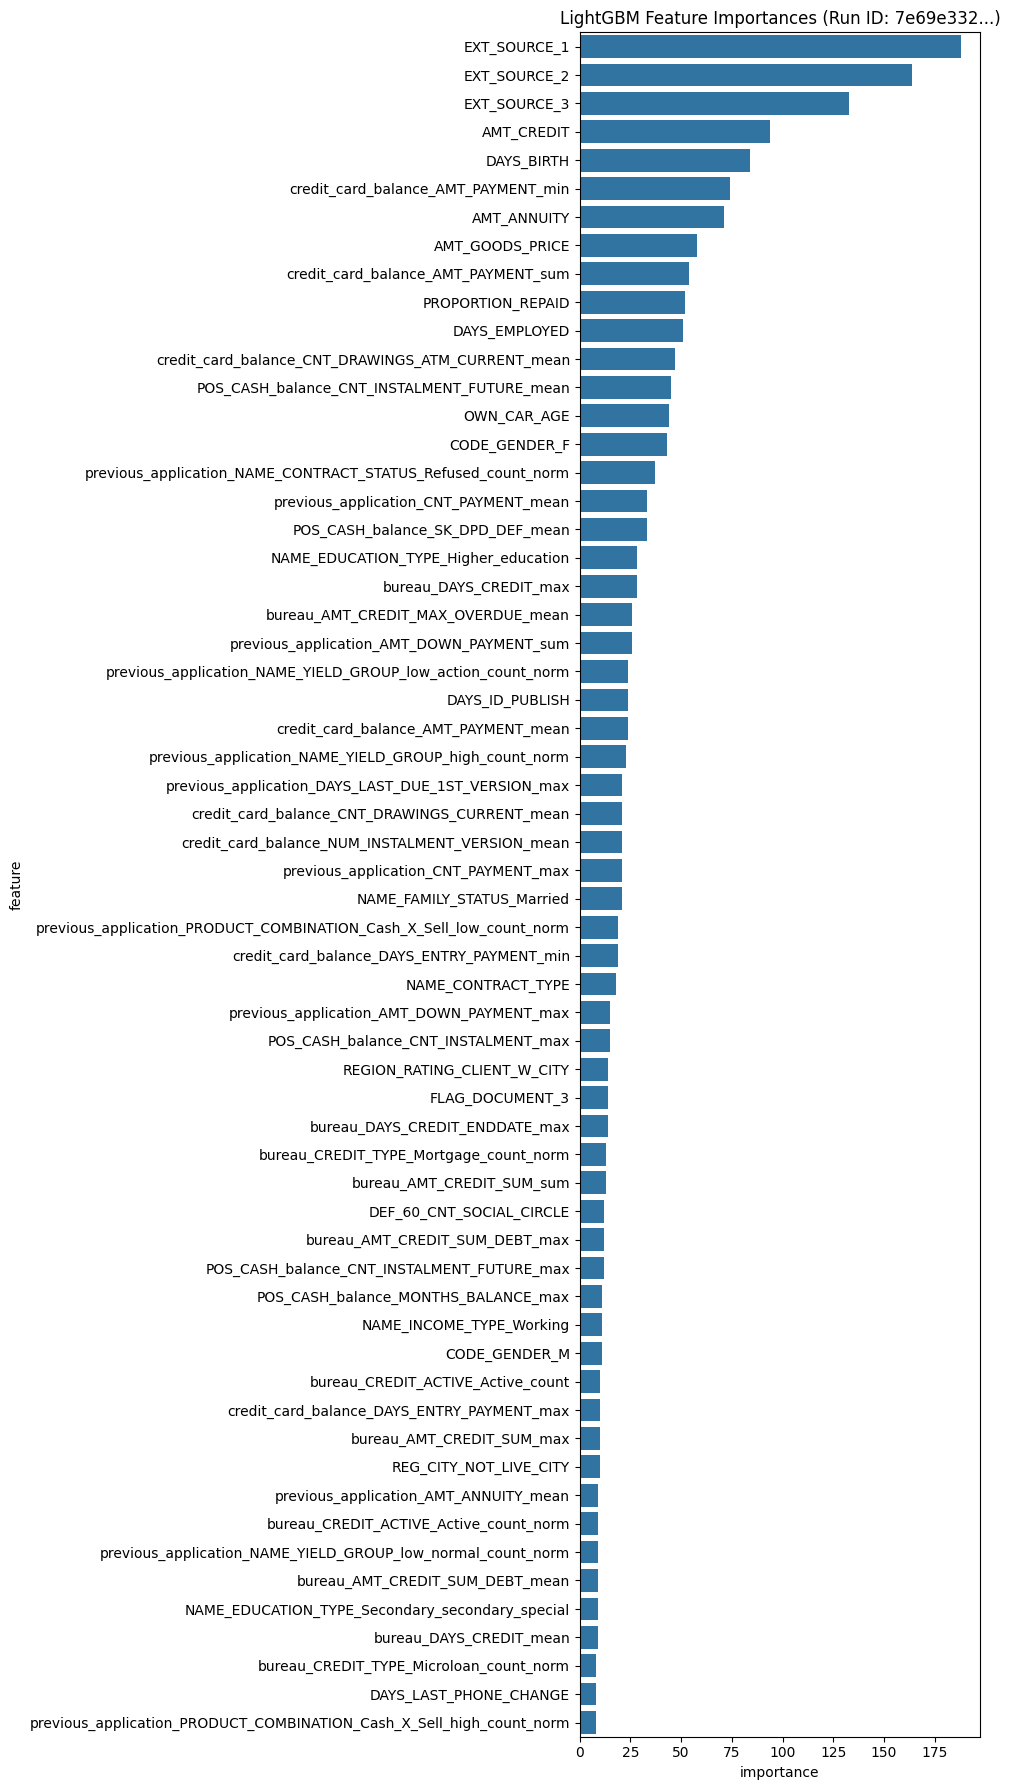

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, max(15, len(feature_importance_df.head(60)) * 0.3))) # Dynamic height
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(60)) # Plot top 60 or fewer
plt.title(f'LightGBM Feature Importances (Run ID: {run_id_to_load[:8]}...)') # Shorten run_id for title
plt.tight_layout()
plt.show()

In [ ]:
zero_importance_features = feature_importance_df[feature_importance_df['importance'] == 0]['feature'].tolist()
print(f"Number of features with ZERO importance: {len(zero_importance_features)}")

Number of features with ZERO importance: 878


In [ ]:
# Get the list of features to KEEP
features_to_keep = feature_importance_df[feature_importance_df['importance'] > 0]['feature'].tolist()
print(f"Number of features with NON-ZERO importance to keep: {len(features_to_keep)}")

# Create new DataFrames with only the selected features
# Ensure the X_train/X_val here are the same ones used to train the model whose importances you extracted
X_train_filtered_with_non_null_importance = X_train[features_to_keep]
X_val_filtered_with_non_null_importance = X_val[features_to_keep]
# X_test_fi_filtered = X_test[features_to_keep] # For later

Number of features with NON-ZERO importance to keep: 261


In [ ]:
X_val_filtered_with_non_null_importance['DAYS_EMPLOYED']

256571      -105
191493     -4930
103497     -1191
130646      -355
211898     -1366
           ...  
16213     365243
294620     -1188
234384     -1194
149027     -1086
268861     -1208
Name: DAYS_EMPLOYED, Length: 61503, dtype: int64

In [ ]:
application_train['DAYS_EMPLOYED'].sort_values(ascending=False)

146327    365243
229266    365243
157475    365243
229294    365243
157480    365243
           ...  
234168    -17522
35191     -17531
208899    -17546
273069    -17583
280994    -17912
Name: DAYS_EMPLOYED, Length: 307511, dtype: int64

# Récupération des paramètres de la baseline

In [ ]:
# --- Enter Baseline run ID ---
run_id_baseline = "80673ee8f1734525b95cebefc59f17f8"

# --- Load the run data ---
client = mlflow.tracking.MlflowClient()
run_data = client.get_run(run_id_baseline).data

# --- Extract the logged best parameters ---
# The keys will have the 'best_gs_' prefix and the estimator name prefix (dans notre cas lgbmclassifier_)
# e.g., 'best_gs_lgbmclassifier__n_estimators'

best_params_from_loaded_run = {}
prefix_to_remove_gs = "best_gs_" # The prefix you added
estimator_prefix = "lgbmclassifier__" # The prefix from pipeline step

for param_key, param_value in run_data.params.items():
    if param_key.startswith(prefix_to_remove_gs):
        # Remove the 'best_gs_' prefix
        original_param_name_with_estimator = param_key[len(prefix_to_remove_gs):]
        # Remove the 'lgbmclassifier__' prefix for direct use with LGBMClassifier
        actual_param_name = original_param_name_with_estimator.replace(estimator_prefix, '')
        best_params_from_loaded_run[actual_param_name] = param_value

print("Best parameters loaded from MLflow run:")
print(best_params_from_loaded_run)

Best parameters loaded from MLflow run:
{'final_class_weight': 'balanced', 'final_learning_rate': '0.05', 'final_num_leaves': '41', 'final_n_estimators': '2000', 'final_n_jobs': '1', 'final_random_state': '42', 'final_reg_alpha': '0.1', 'final_reg_lambda': '0.1', 'learning_rate': '0.05', 'num_leaves': '41', 'n_estimators': '250', 'reg_alpha': '0.1', 'reg_lambda': '0.1'}


# Optimisation de la baseline retenue avec fine tuning de nos hyperparamètres avec GridSearchCV

On va récupérer les meilleurs paramètres trouvés par GridSearchCV sur notre baseline et fine tune à aprtir d'eux

In [ ]:
run_id_baseline = "80673ee8f1734525b95cebefc59f17f8"

In [ ]:
# --- Enter Baseline run ID ---
run_id_baseline = "80673ee8f1734525b95cebefc59f17f8"

# --- Load the run data ---
client = mlflow.tracking.MlflowClient()
run_data = client.get_run(run_id_baseline).data

# --- Extract the logged best parameters ---
# The keys will have the 'best_gs_' prefix and the estimator name prefix (dans notre cas lgbmclassifier_)
# e.g., 'best_gs_lgbmclassifier__n_estimators'

best_params_from_loaded_run = {}
prefix_to_remove_gs = "best_gs_" # The prefix you added
estimator_prefix = "lgbmclassifier__" # The prefix from pipeline step

for param_key, param_value in run_data.params.items():
    if param_key.startswith(prefix_to_remove_gs):
        # Remove the 'best_gs_' prefix
        original_param_name_with_estimator = param_key[len(prefix_to_remove_gs):]
        # Remove the 'lgbmclassifier__' prefix for direct use with LGBMClassifier
        actual_param_name = original_param_name_with_estimator.replace(estimator_prefix, '')
        best_params_from_loaded_run[actual_param_name] = param_value

print("Best parameters loaded from MLflow run:")
print(best_params_from_loaded_run)

Best parameters loaded from MLflow run:
{'final_class_weight': 'balanced', 'final_learning_rate': '0.05', 'final_num_leaves': '41', 'final_n_estimators': '2000', 'final_n_jobs': '1', 'final_random_state': '42', 'final_reg_alpha': '0.1', 'final_reg_lambda': '0.1', 'learning_rate': '0.05', 'num_leaves': '41', 'n_estimators': '250', 'reg_alpha': '0.1', 'reg_lambda': '0.1'}


In [ ]:
original_param_grid = {'lgbmclassifier__n_estimators': [100, 250, 400], 'lgbmclassifier__learning_rate': [0.05, 0.1], 'lgbmclassifier__num_leaves': [21, 31, 41, 51], 'lgbmclassifier__reg_alpha': [0.1], 'lgbmclassifier__reg_lambda': [0.1]}

In [ ]:
X_train_filtered_with_non_null_importance.shape

(246008, 261)

I think the most important one at the moment are the following : trying a lower learning rate so a higher n_estimators is needed as for num leaves given that 41 is slected I would do 36, 39, 42, 45 and not touch the other values first then once I selected one value in particular for these 3 parameters I will change the other hyperparameters this might not be the best course of action but it will ensure that it is not too time consuming and also easier to track the differences bu not changing too many parmeters at once.
So the grid would look something like :
param_grid_next = {
'lgbmclassifier__learning_rate': [0.02, 0.04],
'lgbmclassifier__n_estimators': [400, 600],
'lgbmclassifier__num_leaves': [36, 39, 42, 45],
'lgbmclassifier__reg_alpha': [0.1],
'lgbmclassifier__reg_lambda': [0.1],
 Keep others fixed for now based on previous good values or defaults
'lgbmclassifier__subsample': [0.8],
'lgbmclassifier__colsample_bytree': [0.8],
'lgbmclassifier__min_child_samples': [20]
}

# First fine tuning run for the baseline

In [ ]:
"""
# --- MLflow Experiment Run ---
mlflow.set_experiment("Baseline Fine Tuning (Baseline is GridSearchCV + Threshold Optimization + 878 null features removed)") # To organize runs into experiments

with mlflow.start_run(run_name="First fine tuning run"): #Utile plus tard pour fine tuning

    # 

    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---
    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")

    # Define pipeline FOR GridSearchCV
    # Note: No n_estimators here if it's in param_grid. Early stopping is not directly used IN grid search here.
    lgbm_for_grid = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=1 #Valeur changée en 1 pour soucis mémorie
    )
    pipeline_for_grid = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbmclassifier', lgbm_for_grid)
    ])

    # Define Parameter Grid
    param_grid = {
    'lgbmclassifier__learning_rate': [0.02, 0.04],
    'lgbmclassifier__n_estimators': [400, 600],
    'lgbmclassifier__num_leaves': [36, 39, 42, 45],
    'lgbmclassifier__reg_alpha': [0.1],
    'lgbmclassifier__reg_lambda': [0.1],
    # Keep others fixed for now based on previous good values or defaults
    'lgbmclassifier__subsample': [0.8],
    'lgbmclassifier__colsample_bytree': [0.8],
    'lgbmclassifier__min_child_samples': [20]
    }

    mlflow.log_param("gridsearch_param_grid", str(param_grid))

    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster grid search
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs

    # GridSearchCV - scoring with 'roc_auc' to find robust params
    grid_search = GridSearchCV(
        estimator=pipeline_for_grid,
        param_grid=param_grid,
        scoring='roc_auc', # Focus on good probability ranking first
        cv=cv_strategy,
        verbose=2,
        n_jobs=1 # Use multiple cores if possible
    )

    print("Starting GridSearchCV on X_train, y_train...")
    grid_search.fit(X_train_filtered_with_non_null_importance, y_train) # GridSearchCV takes X_train and y_train. It internally performs cross-validation (e.g., 3-fold or 5-fold). In our case 3-fold
    # For each combination of parameters in the param_grid: It trains the pipeline on k-1 folds. 
    # It evaluates on the 1 held-out fold using the chosen scoring metric (e.g., ROC AUC, calculated using default 0.5 threshold for predictions within the scorer). It averages the scores for each parameter combination across all folds.
    print("GridSearchCV complete.")

    # outputs us the best parameters it found that we store
    best_params_from_grid = grid_search.best_params_
    best_cv_score_grid = grid_search.best_score_

    mlflow.log_params({f"best_gs_{k}": v for k, v in best_params_from_grid.items()}) # Log best params from gridseach

    # for k, v in best_params_from_grid.items(): This part iterates through each key-value pair in the best_params_from_grid dictionary.
    # In each iteration, k will be the parameter name (e.g., 'lgbmclassifier__n_estimators'). v will be the corresponding best value (e.g., 400).



    mlflow.log_metric("gridsearch_best_cv_roc_auc", best_cv_score_grid)

    # --- IMPORTANT We then use the parameters it found to use with our model and then we will train our model on our data using these parameters ---
    

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 200 rounds, print every 100 rounds    
    
    # Define the validation set for early stopping
    eval_set = [(X_val_filtered_with_non_null_importance, y_val)]
   
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)



    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.


    # --- Important --- Etant donné que l'on utilise EarlyStopping on souhaite avoir assez d'itérations pour que EarlyStopping soit pertinent
    # Donc malgré le fait que GridSearchCV nous ait trouvé une valeur pour n_estimators, on vasimplement la remplacer par une valeur élevée pour être sur que EarlyStopping fasse effet

    # 1. Create the base dictionary from GridSearchCV results, stripping prefixes
    
    # In best_params_from_grid which is a dictionnary so we have key value pairs each key so the name of the parameter has the prefix lgbmclassifier__ which we remove for clarity

    final_lgbm_params = {
    key.replace('lgbmclassifier__', ''): value
    for key, value in best_params_from_grid.items()
    }

    # 2. Add/Ensure the fixed base parameters are present because they were not in best_params_from_grid
    #    This will add them if they weren't tuned
    final_lgbm_params['class_weight'] = 'balanced'
    final_lgbm_params['random_state'] = 42
    final_lgbm_params['n_jobs'] = 1 # Changée en 1 pour soucis de mémoire

    # 3. Explicitly set n_estimators to a high value for early stopping.
    #    This will override the n_estimators value that came from GridSearchCV.
    final_lgbm_params['n_estimators'] = 2000


    # --- Define Model & Pipeline ---
    pipeline_lgbm_final = make_pipeline( # Renamed to avoid confusion with grid search pipeline
    StandardScaler(),
    lgb.LGBMClassifier(**final_lgbm_params) # Use the defined parameters ** is for dictionnary unpacking
    )

    mlflow.log_params({f"best_gs_final_{k}": v for k, v in final_lgbm_params.items()}) # Log best params with sligh adjustments

    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---

    print("Training final LGBM model with early stopping...")

    pipeline_lgbm_final.fit(
        X_train_filtered_with_non_null_importance, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric=early_stopping_metric,
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    print("Training part done")

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm_final.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm_final.predict(X_val_filtered_with_non_null_importance)
    y_proba = pipeline_lgbm_final.predict_proba(X_val_filtered_with_non_null_importance)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm_final.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train_filtered_with_non_null_importance.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm_final.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm_final.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))
    """

'\n# --- MLflow Experiment Run ---\nmlflow.set_experiment("Baseline Fine Tuning (Baseline is GridSearchCV + Threshold Optimization + 878 null features removed)") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="First fine tuning run"): #Utile plus tard pour fine tuning\n\n    # \n\n    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---\n    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")\n\n    # Define pipeline FOR GridSearchCV\n    # Note: No n_estimators here if it\'s in param_grid. Early stopping is not directly used IN grid search here.\n    lgbm_for_grid = lgb.LGBMClassifier(\n        class_weight=\'balanced\',\n        random_state=42,\n        n_jobs=1 #Valeur changée en 1 pour soucis mémorie\n    )\n    pipeline_for_grid = Pipeline([\n        (\'scaler\', StandardScaler()),\n        (\'lgbmclassifier\', lgbm_for_grid)\n    ])\n\n    # Define Parameter Grid\n    param_grid = {\n    \'lgbmclassifier__learning_rate\': [0.02, 0.04],\

# Log models

In [ ]:
"""
registered_model_name_in_mlflow = "HomeCredit_Default_Risk_Scoring_Model_v3"

models_to_register_dicts = [

    # First Logistic Regression LogReg_10MostCorrelatedFeatures_MedianImpute_Balanced
    {
        "run_id": "48944224c273441e9bc7bbf1cab15d3b",
        "artifact_path": "logistic_regression_pipeline",
        "description": "LogReg : 10 most correlated features to the target with missing values imputed by median, ROC AUC : 0.718, Accuracy : 0.676",
        "tags": {"dataset_version": "app_train", "model_iteration": "1"}
    },

    # Second Logistic Regression LogReg_10MostCorrelatedFeatures_MedianImpute_Balanced_TunedThreshold
    {
        "run_id": "86041fb956a5431c85f35727971f03bb",
        "artifact_path": "logistic_regression_pipeline",
        "description": "LogReg : 10 most correlated features to the target with missing values imputed by median and threshold tuning, ROC AUC : 0.718, Accuracy : 0.820",
        "tags": {"dataset_version": "app_train", "model_iteration": "2"}
    },

    # Third Logistic Regression LogReg_10MostCorrelatedFeatures_MedianImpute_ManualClassWeights_TunedThreshold
    {
        "run_id": "5bb2affe346a47c2a35a439299aca8e9",
        "artifact_path": "logistic_regression_pipeline",
        "description": "LogReg : 10 most correlated features to the target with missing values imputed by median and threshold tuning and class weights dictionnary, ROC AUC : 0.718, Accuracy : 0.813",
        "tags": {"dataset_version": "app_train", "model_iteration": "3"}
    },

    # LightGBM run with app_train bureau and bureau balance
    {
        "run_id": "a40889e2b22a406e889c572d282bce2a",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : manual features created on bureau and bureau balance combined with app_train, ROC AUC : 0.754, Accuracy : 0.693",
        "tags": {"dataset_version": "app_train_bureau_bureau_balance", "model_iteration": "4"}
    },

    # LightGBM run with app_train bureau and bureau balance and early stopping introduced
    {
        "run_id": "2e43c3bdebc242fc9875333620e12edf",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : manual features created on bureau and bureau balance combined with app_train with early stopping, ROC AUC : 0.748, Accuracy : 0.688",
        "tags": {"dataset_version": "app_train_bureau_bureau_balance", "model_iteration": "5"}
    },

    # LightGBM run with app_train bureau and bureau balance and early stopping introduced and lower lr
    {
        "run_id": "69c6d98449a049d48aadac84e6b885a0",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : manual features created on bureau and bureau balance combined with app_train with early stopping and lower learning rate, ROC AUC : 0.750, Accuracy : 0.690",
        "tags": {"dataset_version": "app_train_bureau_bureau_balance", "model_iteration": "6"}
    },

    # LightGBM run with app_train bureau and bureau balance and early stopping introduced and lower lr and ManualClassWeights
    {
        "run_id": "69c6d98449a049d48aadac84e6b885a0",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : manual features created on bureau and bureau balance combined with app_train with early stopping and lower learning rate and weights dictionnary, ROC AUC : 0.754, Accuracy : 0.878",
        "tags": {"dataset_version": "app_train_bureau_bureau_balance", "model_iteration": "7"}
    },

    # LightGBM run with app_train bureau and bureau balance and early stopping introduced and lower lr and features from both "manual" feature engineering and aggregating functions
    {
        "run_id": "9eec4626c6fe4ec2aae382e3ec060e22",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : manual features created on bureau and bureau balance combined with app_train with early stopping and lower learning rate and weights dictionnary, ROC AUC : 0.744, Accuracy : 0.686",
        "tags": {"dataset_version": "app_train_bureau_bureau_balance_fully_aggregated", "model_iteration": "8"}
    },
    
    # Third Run with full data and business cost and GridSearchCV and threshold optimization
    {
        "run_id": "7e69e332cab3437888b88958c8c24fec",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : Full Data no feature importance, GridSearchCV, ThresholdOptimization, BizCost : -16762, ROC AUC : 0.778, Accuracy : 0.865",
        "tags": {"dataset_version": "full_no_feature_importance", "model_iteration": "9"}
    },

    # Fourth Run with full data and business cost and GridSearchCV and threshold optimization and high correlations removed
    {
        "run_id": "f21fdd62edfd4358b4d8280afb7fa3c0",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : Full Data no feature importance correlations removed, GridSearchCV, ThresholdOptimization, BizCost : -13722, ROC AUC : 0.747, Accuracy : 0.863",
        "tags": {"dataset_version": "full_no_feature_importance_correlations_removed", "model_iteration": "10"}
    },

    # Fifth Run with full data and business cost and GridSearchCV and threshold optimization and 0 importance feature removed
    {
        "run_id": "80673ee8f1734525b95cebefc59f17f8",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : Full Data feature 0 importance removed CURRENT BASELINE, GridSearchCV, ThresholdOptimization, BizCost : -15166, ROC AUC : 0.762, Accuracy : 0.852",
        "tags": {"dataset_version": "full_0_importance_feature_removed", "model_iteration": "11"}
    },

    # Sixth Run with full data and business cost and GridSearchCV and threshold optimization and 0 importance feature removed AGAIN
    {
        "run_id": "85a54bc91d73460597eb049a8b278197",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : Full Data feature 0 importance removed TWICE, GridSearchCV, ThresholdOptimization, BizCost : -13682, ROC AUC : 0.747, Accuracy : 0.866",
        "tags": {"dataset_version": "full_0_importance_feature_removed_TWICE", "model_iteration": "12"}
    },

    # Fine tuning the baseline (model from the fifth run with full data)
    {
        "run_id": "93c821aded144670ba1c054179455a29",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : hyperparameters optimization from the baseline, BizCost : -15004, ROC AUC : 0.759, Accuracy : 0.863",
        "tags": {"dataset_version": "baseline_dataset", "model_iteration": "13"}
    },
        # Fine tuning the baseline further (model from the previous run with full data)
    {
        "run_id": "e486e4775eed4e8381132971007b5ba5",
        "artifact_path": "lightgbm_model",
        "description": "LGBM : hyperparameters optimization from the baseline, BizCost : -14666, ROC AUC : 0.758, Accuracy : 0.863",
        "tags": {"dataset_version": "baseline_dataset", "model_iteration": "14"}
    },    

        # Final model
    {
        "run_id": "dc6fb5c5f64e4a90b08ca76d9b962765",
        "artifact_path": "lightgbm_model",
        "description": "Final version, BizCost : -15166, ROC AUC : 0.762, Accuracy : 0.852",
        "tags": {"dataset_version": "full_0_importance_feature_removed", "model_iteration": "15"}
    },
]

print(f"  Registering selected models under the name '{registered_model_name_in_mlflow}' in MLflow Model Registry...") #Indentation dans le print pour faire comme un sommaire
client = mlflow.tracking.MlflowClient()

for model_info in models_to_register_dicts: # .get() commun à utiliser avec dictionnaires (voir script API)
    run_id = model_info["run_id"]
    artifact_path = model_info["artifact_path"]
    description = model_info.get("description", f"Model from run {run_id}") # On utilise .get() qui permet au code de ne pas retourner d'erreur si on ne spécifie rien dans description ou tags par example si la clé description n'existe pas le .get() retournera f"Model from run {run_id}"
    tags = model_info.get("tags", None) # Meme logique que juste au dessus

    model_uri = f"runs:/{run_id}/{artifact_path}"

    print(f"    Registering model from Run ID: {run_id}, Artifact Path: {artifact_path}")
    try: # Try except block is a good practice when going through dictionnaries not really needed there but good practice with loops, external data sources, ... If it was for example a dictionnary of dictionnaries that I had gooten from an API request it would be needed
        model_version_details = mlflow.register_model(
            model_uri=model_uri,
            name=registered_model_name_in_mlflow
        )
        print(f"    Registered: Name='{model_version_details.name}', Version='{model_version_details.version}'")

        # Update description for this new version
        client.update_model_version(
            name=registered_model_name_in_mlflow,
            version=model_version_details.version,
            description=description
        )
        print(f"    Description updated for Version {model_version_details.version}.")

        # Set tags if provided
        if tags:
            for tag_key, tag_value in tags.items():
                client.set_model_version_tag(
                    name=registered_model_name_in_mlflow,
                    version=model_version_details.version,
                    key=tag_key,
                    value=tag_value
                )
            print(f"    Tags added for Version {model_version_details.version}.")

        # TO manually transition stages in the UI or programmatically:
        # client.transition_model_version_stage(
        #     name=registered_model_name_in_mlflow,
        #     version=model_version_details.version,
        #     stage="Staging" # or "Production", "Archived"
        # )
        # print(f"    Version {model_version_details.version} transitioned to Staging (Example).")
        print("-" * 30)

    except Exception as e:
        print(f"    ERROR registering model from Run ID {run_id}: {e}")
        print("-" * 30)

print("\nModel registration process complete. Check the 'Models' tab in MLflow UI.")
"""

'\nregistered_model_name_in_mlflow = "HomeCredit_Default_Risk_Scoring_Model_v3"\n\nmodels_to_register_dicts = [\n\n    # First Logistic Regression LogReg_10MostCorrelatedFeatures_MedianImpute_Balanced\n    {\n        "run_id": "48944224c273441e9bc7bbf1cab15d3b",\n        "artifact_path": "logistic_regression_pipeline",\n        "description": "LogReg : 10 most correlated features to the target with missing values imputed by median, ROC AUC : 0.718, Accuracy : 0.676",\n        "tags": {"dataset_version": "app_train", "model_iteration": "1"}\n    },\n\n    # Second Logistic Regression LogReg_10MostCorrelatedFeatures_MedianImpute_Balanced_TunedThreshold\n    {\n        "run_id": "86041fb956a5431c85f35727971f03bb",\n        "artifact_path": "logistic_regression_pipeline",\n        "description": "LogReg : 10 most correlated features to the target with missing values imputed by median and threshold tuning, ROC AUC : 0.718, Accuracy : 0.820",\n        "tags": {"dataset_version": "app_train",

# Second fine tuning run

In [ ]:
previous_run_id = "93c821aded144670ba1c054179455a29"

# --- Load the run data ---
client = mlflow.tracking.MlflowClient()
run_data = client.get_run(previous_run_id).data

# --- Extract the logged best parameters ---
# The keys will have the 'best_gs_' prefix and the estimator name prefix (dans notre cas lgbmclassifier_)
# e.g., 'best_gs_lgbmclassifier__n_estimators'

best_params_from_loaded_run = {}
prefix_to_remove_gs = "best_gs_" # The prefix you added
estimator_prefix = "lgbmclassifier__" # The prefix from pipeline step

for param_key, param_value in run_data.params.items():
    if param_key.startswith(prefix_to_remove_gs):
        # Remove the 'best_gs_' prefix
        original_param_name_with_estimator = param_key[len(prefix_to_remove_gs):]
        # Remove the 'lgbmclassifier__' prefix for direct use with LGBMClassifier
        actual_param_name = original_param_name_with_estimator.replace(estimator_prefix, '')
        best_params_from_loaded_run[actual_param_name] = param_value

print("Best parameters loaded from MLflow run:")
print(best_params_from_loaded_run)

Best parameters loaded from MLflow run:
{'final_class_weight': 'balanced', 'final_colsample_bytree': '0.8', 'final_learning_rate': '0.02', 'final_min_child_samples': '20', 'final_num_leaves': '45', 'final_n_estimators': '2000', 'final_n_jobs': '1', 'final_random_state': '42', 'final_reg_alpha': '0.1', 'final_reg_lambda': '0.1', 'final_subsample': '0.8', 'colsample_bytree': '0.8', 'learning_rate': '0.02', 'min_child_samples': '20', 'num_leaves': '45', 'n_estimators': '600', 'reg_alpha': '0.1', 'reg_lambda': '0.1', 'subsample': '0.8'}


In [ ]:
previous_run_id = "93c821aded144670ba1c054179455a29"

# --- Load the run data ---
client = mlflow.tracking.MlflowClient()
run_data = client.get_run(previous_run_id).data

# --- Extract the logged best parameters ---
# The keys will have the 'best_gs_' prefix and the estimator name prefix (dans notre cas lgbmclassifier_)
# e.g., 'best_gs_lgbmclassifier__n_estimators'

best_params_from_loaded_run = {}
prefix_to_remove_gs = "best_gs_" # The prefix you added
estimator_prefix = "lgbmclassifier__" # The prefix from pipeline step

for param_key, param_value in run_data.params.items():
    if param_key.startswith(prefix_to_remove_gs):
        # Remove the 'best_gs_' prefix
        original_param_name_with_estimator = param_key[len(prefix_to_remove_gs):]
        # Remove the 'lgbmclassifier__' prefix for direct use with LGBMClassifier
        actual_param_name = original_param_name_with_estimator.replace(estimator_prefix, '')
        best_params_from_loaded_run[actual_param_name] = param_value

print("Best parameters loaded from MLflow run:")
print(best_params_from_loaded_run)

Best parameters loaded from MLflow run:
{'final_class_weight': 'balanced', 'final_colsample_bytree': '0.8', 'final_learning_rate': '0.02', 'final_min_child_samples': '20', 'final_num_leaves': '45', 'final_n_estimators': '2000', 'final_n_jobs': '1', 'final_random_state': '42', 'final_reg_alpha': '0.1', 'final_reg_lambda': '0.1', 'final_subsample': '0.8', 'colsample_bytree': '0.8', 'learning_rate': '0.02', 'min_child_samples': '20', 'num_leaves': '45', 'n_estimators': '600', 'reg_alpha': '0.1', 'reg_lambda': '0.1', 'subsample': '0.8'}


In [ ]:
param_grid_from_previous_run =     param_grid = {
    'lgbmclassifier__learning_rate': [0.02, 0.04],
    'lgbmclassifier__n_estimators': [400, 600],
    'lgbmclassifier__num_leaves': [36, 39, 42, 45],
    'lgbmclassifier__reg_alpha': [0.1],
    'lgbmclassifier__reg_lambda': [0.1],
    # Keep others fixed for now based on previous good values or defaults
    'lgbmclassifier__subsample': [0.8],
    'lgbmclassifier__colsample_bytree': [0.8],
    'lgbmclassifier__min_child_samples': [20]
    }


In [ ]:
best_params_from_loaded_run

{'final_class_weight': 'balanced',
 'final_colsample_bytree': '0.8',
 'final_learning_rate': '0.02',
 'final_min_child_samples': '20',
 'final_num_leaves': '45',
 'final_n_estimators': '2000',
 'final_n_jobs': '1',
 'final_random_state': '42',
 'final_reg_alpha': '0.1',
 'final_reg_lambda': '0.1',
 'final_subsample': '0.8',
 'colsample_bytree': '0.8',
 'learning_rate': '0.02',
 'min_child_samples': '20',
 'num_leaves': '45',
 'n_estimators': '600',
 'reg_alpha': '0.1',
 'reg_lambda': '0.1',
 'subsample': '0.8'}

In [ ]:
"""
# --- MLflow Experiment Run ---
mlflow.set_experiment("Baseline Fine Tuning (Baseline is GridSearchCV + Threshold Optimization + 878 null features removed)") # To organize runs into experiments

with mlflow.start_run(run_name="Second fine tuning run"): #Utile plus tard pour fine tuning

    # 

    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---
    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")

    # Define pipeline FOR GridSearchCV
    # Note: No n_estimators here if it's in param_grid. Early stopping is not directly used IN grid search here.
    lgbm_for_grid = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=1 #Valeur changée en 1 pour soucis mémorie
    )
    pipeline_for_grid = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbmclassifier', lgbm_for_grid)
    ])

    # Define Parameter Grid
    param_grid = {
    'lgbmclassifier__learning_rate': [0.02],         
    'lgbmclassifier__n_estimators': [500, 600, 700],   
    'lgbmclassifier__num_leaves': [40, 45, 50],        
    'lgbmclassifier__reg_alpha': [0.05, 0.1, 0.2],     
    'lgbmclassifier__reg_lambda': [0.05, 0.1, 0.2],   
    # Keep these fixed based on good defaults or previous bests to limit combinations
    'lgbmclassifier__subsample': [0.8],
    'lgbmclassifier__colsample_bytree': [0.8],
    'lgbmclassifier__min_child_samples': [20]
    }

    mlflow.log_param("gridsearch_param_grid", str(param_grid))

    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster grid search
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs

    # GridSearchCV - scoring with 'roc_auc' to find robust params
    grid_search = GridSearchCV(
        estimator=pipeline_for_grid,
        param_grid=param_grid,
        scoring='roc_auc', # Focus on good probability ranking first
        cv=cv_strategy,
        verbose=2,
        n_jobs=1 # Use multiple cores if possible
    )

    print("Starting GridSearchCV on X_train, y_train...")
    grid_search.fit(X_train_filtered_with_non_null_importance, y_train) # GridSearchCV takes X_train and y_train. It internally performs cross-validation (e.g., 3-fold or 5-fold). In our case 3-fold
    # For each combination of parameters in the param_grid: It trains the pipeline on k-1 folds. 
    # It evaluates on the 1 held-out fold using the chosen scoring metric (e.g., ROC AUC, calculated using default 0.5 threshold for predictions within the scorer). It averages the scores for each parameter combination across all folds.
    print("GridSearchCV complete.")

    # outputs us the best parameters it found that we store
    best_params_from_grid = grid_search.best_params_
    best_cv_score_grid = grid_search.best_score_

    mlflow.log_params({f"best_gs_{k}": v for k, v in best_params_from_grid.items()}) # Log best params from gridseach

    # for k, v in best_params_from_grid.items(): This part iterates through each key-value pair in the best_params_from_grid dictionary.
    # In each iteration, k will be the parameter name (e.g., 'lgbmclassifier__n_estimators'). v will be the corresponding best value (e.g., 400).



    mlflow.log_metric("gridsearch_best_cv_roc_auc", best_cv_score_grid)

    # --- IMPORTANT We then use the parameters it found to use with our model and then we will train our model on our data using these parameters ---
    

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 200 rounds, print every 100 rounds    
    
    # Define the validation set for early stopping
    eval_set = [(X_val_filtered_with_non_null_importance, y_val)]
   
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)



    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.


    # --- Important --- Etant donné que l'on utilise EarlyStopping on souhaite avoir assez d'itérations pour que EarlyStopping soit pertinent
    # Donc malgré le fait que GridSearchCV nous ait trouvé une valeur pour n_estimators, on vasimplement la remplacer par une valeur élevée pour être sur que EarlyStopping fasse effet

    # 1. Create the base dictionary from GridSearchCV results, stripping prefixes
    
    # In best_params_from_grid which is a dictionnary so we have key value pairs each key so the name of the parameter has the prefix lgbmclassifier__ which we remove for clarity

    final_lgbm_params = {
    key.replace('lgbmclassifier__', ''): value
    for key, value in best_params_from_grid.items()
    }

    # 2. Add/Ensure the fixed base parameters are present because they were not in best_params_from_grid
    #    This will add them if they weren't tuned
    final_lgbm_params['class_weight'] = 'balanced'
    final_lgbm_params['random_state'] = 42
    final_lgbm_params['n_jobs'] = 1 # Changée en 1 pour soucis de mémoire

    # 3. Explicitly set n_estimators to a high value for early stopping.
    #    This will override the n_estimators value that came from GridSearchCV.
    final_lgbm_params['n_estimators'] = 2000


    # --- Define Model & Pipeline ---
    pipeline_lgbm_final = make_pipeline( # Renamed to avoid confusion with grid search pipeline
    StandardScaler(),
    lgb.LGBMClassifier(**final_lgbm_params) # Use the defined parameters ** is for dictionnary unpacking
    )

    mlflow.log_params({f"best_gs_final_{k}": v for k, v in final_lgbm_params.items()}) # Log best params with sligh adjustments

    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---

    print("Training final LGBM model with early stopping...")

    pipeline_lgbm_final.fit(
        X_train_filtered_with_non_null_importance, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric=early_stopping_metric,
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    print("Training part done")

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm_final.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm_final.predict(X_val_filtered_with_non_null_importance)
    y_proba = pipeline_lgbm_final.predict_proba(X_val_filtered_with_non_null_importance)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.lightgbm.log_model(
        lgb_model=pipeline_lgbm_final.named_steps['lgbmclassifier'], # Log the LGBM step
        artifact_path="lightgbm_model",
        input_example=X_train_filtered_with_non_null_importance.head(5) # Provide example
        )


    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm_final.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm_final.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))
    """

'\n# --- MLflow Experiment Run ---\nmlflow.set_experiment("Baseline Fine Tuning (Baseline is GridSearchCV + Threshold Optimization + 878 null features removed)") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="Second fine tuning run"): #Utile plus tard pour fine tuning\n\n    # \n\n    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---\n    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")\n\n    # Define pipeline FOR GridSearchCV\n    # Note: No n_estimators here if it\'s in param_grid. Early stopping is not directly used IN grid search here.\n    lgbm_for_grid = lgb.LGBMClassifier(\n        class_weight=\'balanced\',\n        random_state=42,\n        n_jobs=1 #Valeur changée en 1 pour soucis mémorie\n    )\n    pipeline_for_grid = Pipeline([\n        (\'scaler\', StandardScaler()),\n        (\'lgbmclassifier\', lgbm_for_grid)\n    ])\n\n    # Define Parameter Grid\n    param_grid = {\n    \'lgbmclassifier__learning_rate\': [0.02],      

 # Logging the final model

In [ ]:
"""
# --- MLflow Experiment Run ---
mlflow.set_experiment("Final LightGBM Scoring Model") # To organize runs into experiments

with mlflow.start_run(run_name="Model to put into production"): #Utile plus tard pour fine tuning

    # 

    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---
    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")

    # Define pipeline FOR GridSearchCV
    # Note: No n_estimators here if it's in param_grid. Early stopping is not directly used IN grid search here.
    lgbm_for_grid = lgb.LGBMClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=1 #Valeur changée en 1 pour soucis mémorie
    )
    pipeline_for_grid = Pipeline([
        ('scaler', StandardScaler()),
        ('lgbmclassifier', lgbm_for_grid)
    ])

    # Define Parameter Grid
    param_grid = {
        'lgbmclassifier__n_estimators': [100, 250, 400],       # 3 options
        'lgbmclassifier__learning_rate': [0.05],          # 2 options
        'lgbmclassifier__num_leaves': [41],        # 4 options
        'lgbmclassifier__reg_alpha': [0.1],                    # 1 option
        'lgbmclassifier__reg_lambda': [0.1],                   # 1 option
    # Let's keep subsampling fixed for now to limit combinations
    # 'lgbmclassifier__subsample': [0.8, 0.9],
    # 'lgbmclassifier__colsample_bytree': [0.8, 0.9]
    }

    mlflow.log_param("gridsearch_param_grid", str(param_grid))

    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for faster grid search
    
    nan_handling_strategy = "LGBM_internal" # On laisse LightGBM gérer les NaNs

    # GridSearchCV - scoring with 'roc_auc' to find robust params
    grid_search = GridSearchCV(
        estimator=pipeline_for_grid,
        param_grid=param_grid,
        scoring='roc_auc', # Focus on good probability ranking first
        cv=cv_strategy,
        verbose=2,
        n_jobs=1 # Use multiple cores if possible
    )

    print("Starting GridSearchCV on X_train, y_train...")
    grid_search.fit(X_train_filtered_with_non_null_importance, y_train) # GridSearchCV takes X_train and y_train. It internally performs cross-validation (e.g., 3-fold or 5-fold). In our case 3-fold
    # For each combination of parameters in the param_grid: It trains the pipeline on k-1 folds. 
    # It evaluates on the 1 held-out fold using the chosen scoring metric (e.g., ROC AUC, calculated using default 0.5 threshold for predictions within the scorer). It averages the scores for each parameter combination across all folds.
    print("GridSearchCV complete.")

    # outputs us the best parameters it found that we store
    best_params_from_grid = grid_search.best_params_
    best_cv_score_grid = grid_search.best_score_

    mlflow.log_params({f"best_gs_{k}": v for k, v in best_params_from_grid.items()}) # Log best params from gridseach

    # for k, v in best_params_from_grid.items(): This part iterates through each key-value pair in the best_params_from_grid dictionary.
    # In each iteration, k will be the parameter name (e.g., 'lgbmclassifier__n_estimators'). v will be the corresponding best value (e.g., 400).



    mlflow.log_metric("gridsearch_best_cv_roc_auc", best_cv_score_grid)

    # --- IMPORTANT We then use the parameters it found to use with our model and then we will train our model on our data using these parameters ---
    

    # --- Definition des callbacks ---

    stopping_rounds=200
    verbose=100
    early_stopping_metric = 'auc'

    #liste de callbacks qu'on va mettre dans le fit pour dire quels callbacks notre modèle doit utiliser durant l'entrainement
    callbacks_list = [lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=verbose)] # Stop if val AUC doesn't improve for 200 rounds, print every 100 rounds    
    
    # Define the validation set for early stopping
    eval_set = [(X_val_filtered_with_non_null_importance, y_val)]
   
    # --- Log Callbacks parameters

    mlflow.log_param("early_stopping_enabled", True)
    mlflow.log_param("early_stopping_rounds", stopping_rounds)
    mlflow.log_param("early_stopping_metric", early_stopping_metric)



    # --- IMPORTANT --- Meme si LightGBM utilise par défaut binary logloss ici on va utiliser ROC AUC car :
    # Log loss can sometimes be sensitive to outliers or poorly calibrated probabilities. It might not perfectly align with the final business metric you care about (which might be AUC, F1, precision, recall, etc.).
    # ROC AUX a aussi ses désavantages : Cons: AUC is threshold-independent, so stopping based on it doesn't guarantee optimal performance at the specific threshold you might choose later (though it's usually highly correlated).
    # Mais globalement AUC is a common and robust metric for evaluating binary classifier performance, especially with imbalanced datasets. It measures the model's ability to rank positive instances higher than negative ones, irrespective of the specific threshold. 
    # Stopping based on validation AUC ensures you stop when this ranking ability stops improving. Often aligns better with overall classification quality goals than log loss.
    # Le seul vrai avantage d'utiliser la même métrique que celle que le modèle regarde pendant son entrainement ici la log loss c'est que :
    # Directly related to the function the model is optimizing. Stopping based on validation log loss ensures you stop when the model's probabilistic predictions stop improving on unseen data according to that specific loss function.


    # --- Important --- Etant donné que l'on utilise EarlyStopping on souhaite avoir assez d'itérations pour que EarlyStopping soit pertinent
    # Donc malgré le fait que GridSearchCV nous ait trouvé une valeur pour n_estimators, on vasimplement la remplacer par une valeur élevée pour être sur que EarlyStopping fasse effet

    # 1. Create the base dictionary from GridSearchCV results, stripping prefixes
    
    # In best_params_from_grid which is a dictionnary so we have key value pairs each key so the name of the parameter has the prefix lgbmclassifier__ which we remove for clarity

    final_lgbm_params = {
    key.replace('lgbmclassifier__', ''): value
    for key, value in best_params_from_grid.items()
    }

    # 2. Add/Ensure the fixed base parameters are present because they were not in best_params_from_grid
    #    This will add them if they weren't tuned
    final_lgbm_params['class_weight'] = 'balanced'
    final_lgbm_params['random_state'] = 42
    final_lgbm_params['n_jobs'] = 1 # Changée en 1 pour soucis de mémoire

    # 3. Explicitly set n_estimators to a high value for early stopping.
    #    This will override the n_estimators value that came from GridSearchCV.
    final_lgbm_params['n_estimators'] = 2000


    # --- Define Model & Pipeline ---
    pipeline_lgbm_final = make_pipeline( # Renamed to avoid confusion with grid search pipeline
    StandardScaler(),
    lgb.LGBMClassifier(**final_lgbm_params) # Use the defined parameters ** is for dictionnary unpacking
    )

    mlflow.log_params({f"best_gs_final_{k}": v for k, v in final_lgbm_params.items()}) # Log best params with sligh adjustments

    # --- Log Parameters ---
    mlflow.log_param("model_type", "LightGBM") # Updated
    mlflow.log_param("imputation_merge_nans", "ZeroFill") # Example for merge NaNs
    mlflow.log_param("nan_handling_model", nan_handling_strategy) # Log NaN strategy
    mlflow.log_param("scaling", "StandardScaler")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("train_val_split", 0.2)

    # --- Train model ---

    print("Training final LGBM model with early stopping...")

    pipeline_lgbm_final.fit(
        X_train_filtered_with_non_null_importance, y_train,
        # Pass eval_set for early stopping
        lgbmclassifier__eval_set=eval_set, #eval_set est une liste contenant des validation sets (as tuples of (X_val, y_val)) pour controler/monitor performances. Early stopping uses this to decide when to stop.
        lgbmclassifier__eval_metric=early_stopping_metric,
        # Use callbacks argument for early stopping
        lgbmclassifier__callbacks=callbacks_list
        )
    
    print("Training part done")

    # --- After fitting ---
    
    #  --- IMPORTANT ---best_iteration as a metric tells us how many trees were actually used in the final model selected by early stopping
    fitted_lgbm = pipeline_lgbm_final.named_steps['lgbmclassifier']
    if fitted_lgbm.best_iteration_:
        mlflow.log_metric("best_iteration", fitted_lgbm.best_iteration_)
        # Optional: Update the n_estimators param if you want to reflect the stopped value
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.best_iteration_)
    else:
        # Log if early stopping didn't trigger (ran full n_estimators)
        mlflow.log_metric("best_iteration", fitted_lgbm.n_estimators)
        # mlflow.log_param("actual_n_estimators", fitted_lgbm.n_estimators)

    # --- Predict & Calcul des métriques ---
    y_pred = pipeline_lgbm_final.predict(X_val_filtered_with_non_null_importance)
    y_proba = pipeline_lgbm_final.predict_proba(X_val_filtered_with_non_null_importance)[:, 1] # Probabilities for class 1

    # --- Find the best threshold to minimize business cost ---
    
    # 1. Defining a range of thresholds
    thresholds_to_try = np.linspace(0.01, 0.99, 100) # Trying 100 thresholds

    # 2. Initialize variables to store the best findings
    min_val_cost = float('inf') # Initialize minimum cost to positive infinity (so any real cost will be lower)
    best_val_threshold_cost = 0.5 # Initialize best threshold to a default (e.g., 0.5)
    y_pred_val_at_min_cost = None # To store the predictions made using the best threshold

    # 3. Loop through each threshold
    print("Optimizing threshold for business cost on validation set...")
    for threshold in thresholds_to_try:
    # 3a. Convert probabilities to class predictions based on the current threshold
        y_pred_temp_val = (y_proba >= threshold).astype(int)
    # If y_val_proba is >= current threshold, predict 1 (default), else predict 0 (repay)

    # 3b. Calculate the business cost using these temporary predictions
        current_val_cost = calculate_business_cost(y_val, y_pred_temp_val,
                                             cost_fn=10, cost_fp=1, cost_tn=(-1))

    # 3c. Check if this threshold gives a lower cost
        if current_val_cost < min_val_cost:           # Initial value is positive infinity so first one always registered an then only lower business costs can replace it
            min_val_cost = current_val_cost           # Update minimum cost
            best_val_threshold_cost = threshold       # Update best threshold
            y_pred_val_at_min_cost = y_pred_temp_val  # Store these predictions

    # 4. Output the results
    print(f"\nBest threshold (validation) to minimize business cost: {best_val_threshold_cost:.4f}")
    print(f"Minimum business cost on validation set: {min_val_cost}")
    # y_pred_val_at_min_cost now holds the predictions that achieve this minimum cost

    accuracy = accuracy_score(y_val, y_pred_val_at_min_cost)
    f1 = f1_score(y_val, y_pred_val_at_min_cost) # Default F1 for class 1
    roc_auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred_val_at_min_cost, output_dict=True) # Get report as dict

    # --- Log métriques ---
    mlflow.log_metric("best_business_cost_obtained", min_val_cost)
    mlflow.log_metric("best_threshold_to_minimize_business_cost", best_val_threshold_cost)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("val_f1_score", f1)
    mlflow.log_metric("val_roc_auc", roc_auc)
    # metrics from classification report
    mlflow.log_metric("val_precision_0", report['0']['precision'])
    mlflow.log_metric("val_recall_0", report['0']['recall'])
    mlflow.log_metric("val_f1_0", report['0']['f1-score'])
    mlflow.log_metric("val_precision_1", report['1']['precision'])
    mlflow.log_metric("val_recall_1", report['1']['recall'])
    mlflow.log_metric("val_f1_1", report['1']['f1-score'])

    # --- Input Example ---
    input_example = X_train.head(5) #Input example = small sample of valid input data (like one or a few rows from X_train or X_val DataFrame) that demonstrates the expected format.
    #Sert a si jamais on souhaite se resservir du modèle à ce qu'il vérifie que les données d'entrée aient le format attendu ici DataFrame Pandas

    # --- Log Model ---
    mlflow.sklearn.log_model(
        sk_model=pipeline_lgbm_final, # Log the ENTIRE pipeline to be able to also get the scaler
        artifact_path="full_lgbm_pipeline",
        input_example=X_train_filtered_with_non_null_importance.head(5)
    )

    # --- Log Artifacts (Example: Confusion Matrix) ---
    cm = confusion_matrix(y_val, y_pred_val_at_min_cost, labels=pipeline_lgbm_final.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_lgbm_final.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix LGBM (Validation Set)")
    cm_path = "confusion_matrix_lgbm_val.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close() # Close the plot to prevent display in notebook output if desired

    print(f"Run ID: {mlflow.active_run().info.run_id} logged.")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
    print(f"Business cost: {min_val_cost}")
    print(classification_report(y_val, y_pred_val_at_min_cost))
    """

'\n# --- MLflow Experiment Run ---\nmlflow.set_experiment("Final LightGBM Scoring Model") # To organize runs into experiments\n\nwith mlflow.start_run(run_name="Model to put into production"): #Utile plus tard pour fine tuning\n\n    # \n\n    # --- STAGE 1: HYPERPARAMETER TUNING WITH GRIDSEARCHCV ---\n    print("--- Stage 1: Hyperparameter Tuning with GridSearchCV ---")\n\n    # Define pipeline FOR GridSearchCV\n    # Note: No n_estimators here if it\'s in param_grid. Early stopping is not directly used IN grid search here.\n    lgbm_for_grid = lgb.LGBMClassifier(\n        class_weight=\'balanced\',\n        random_state=42,\n        n_jobs=1 #Valeur changée en 1 pour soucis mémorie\n    )\n    pipeline_for_grid = Pipeline([\n        (\'scaler\', StandardScaler()),\n        (\'lgbmclassifier\', lgbm_for_grid)\n    ])\n\n    # Define Parameter Grid\n    param_grid = {\n        \'lgbmclassifier__n_estimators\': [100, 250, 400],       # 3 options\n        \'lgbmclassifier__learning_rate\

# Export datasets pour analyse data_drift

In [ ]:
filename = "X_train_filtered_with_non_null_importance.csv"
X_train_filtered_with_non_null_importance.to_csv(filename)
filename_2 = "X_test_filtered_with_non_null_importance.csv"
X_test_filtered_with_non_null_importance.to_csv(filename_2)

# Analyse SHAP du modèle retenu

## SHAP plotting

On va load le modèle entrainé sur le jeu de données avec les 878 features enlevées

In [ ]:
model_pkl_path = r'C:\Users\Maxime\Desktop\Homre_Credit_Project_Ver2\Home_Credit_Project_Ver2\mlruns\448441841985485771\dc6fb5c5f64e4a90b08ca76d9b962765\artifacts\full_lgbm_pipeline\model.pkl'
loaded_piepline = joblib.load(model_pkl_path)

In [ ]:
# Load the entire pipeline
loaded_pipeline = joblib.load(model_pkl_path)
print(f"Pipeline loaded: {loaded_pipeline}")
print(f"Pipeline steps: {loaded_pipeline.steps}")

Pipeline loaded: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.05,
                                n_estimators=2000, n_jobs=1, num_leaves=41,
                                random_state=42, reg_alpha=0.1,
                                reg_lambda=0.1))])
Pipeline steps: [('standardscaler', StandardScaler()), ('lgbmclassifier', LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=2000,
               n_jobs=1, num_leaves=41, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1))]


In [ ]:
columns_order = X_train_filtered_with_non_null_importance.columns
X_test_filtered_with_non_null_importance = X_test_filtered_with_non_null_importance[columns_order]

In [ ]:
X_test_filtered_with_non_null_importance_unscaled = X_test_filtered_with_non_null_importance.copy()
scaler = loaded_pipeline.named_steps['standardscaler']
lgbm_model = loaded_pipeline.named_steps['lgbmclassifier']
X_test_filtered_with_non_null_importance_scaled = scaler.transform(X_test_filtered_with_non_null_importance_unscaled)


In [ ]:
X_test_filtered_with_non_null_importance_scaled_df = pd.DataFrame(X_test_filtered_with_non_null_importance_scaled, columns=columns_order)

In [ ]:
X_test_filtered_with_non_null_importance_scaled_df

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,AMT_CREDIT,DAYS_BIRTH,credit_card_balance_AMT_PAYMENT_min,AMT_ANNUITY,AMT_GOODS_PRICE,credit_card_balance_AMT_PAYMENT_sum,PROPORTION_REPAID,...,ORGANIZATION_TYPE_School,credit_card_balance_AMT_INSTALMENT_min,credit_card_balance_AMT_PAYMENT_CURRENT_sum,FLOORSMAX_MODE,previous_application_NAME_TYPE_SUITE_Unaccompanied_count_norm,POS_CASH_balance_CNT_INSTALMENT_sum,previous_application_CODE_REJECT_REASON_SCOFR_count_norm,POS_CASH_balance_CNT_INSTALMENT_min,OCCUPATION_TYPE_Accountants,client_bureau_balance_STATUS_C_count_min
0,1.187087,1.440683,-1.803929,-0.075829,-0.736096,-0.089093,-0.450909,-0.239866,-0.695716,0.071188,...,-0.173376,-0.216034,NaN,-0.677022,-0.961060,-0.795820,-0.130054,-0.669050,-0.181934,-0.33838
1,0.299604,-1.164932,-0.400007,-0.935056,-0.466319,-0.027778,-0.670627,-0.970396,-0.679389,-1.331778,...,-0.173376,-0.154310,NaN,NaN,-0.961060,-0.657498,-0.130054,0.217789,-0.181934,-0.33838
2,NaN,0.970481,0.514043,0.158733,-0.918774,-0.369632,2.938453,0.247155,0.906395,-1.709120,...,-0.173376,-0.494049,0.809129,NaN,0.727461,0.457619,-0.130054,-0.314314,-0.181934,-0.33838
3,0.113918,-0.024206,0.522837,2.422650,0.470681,-0.369987,1.508891,2.804012,-0.203570,-0.211482,...,-0.173376,-0.498797,-0.052554,1.064097,-0.961060,0.220251,-0.130054,-0.491682,-0.181934,-0.33838
4,-1.416693,-0.463655,NaN,0.064962,0.685219,0.419129,0.341502,0.234979,-0.595339,NaN,...,-0.173376,0.295572,NaN,NaN,0.727461,-0.590898,-0.130054,0.749891,-0.181934,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,NaN,0.702531,0.678515,-0.463786,-0.903188,0.641364,-0.663499,-0.726886,-0.442709,-0.196868,...,-0.173376,0.519285,NaN,NaN,2.415983,-0.729221,-0.130054,-0.846417,-0.181934,-0.33838
48740,NaN,0.890998,NaN,0.057297,1.110170,-0.369879,0.330656,-0.118111,-0.121743,NaN,...,-0.173376,-0.237299,NaN,NaN,-0.116799,1.642750,-0.130054,0.395156,-0.181934,NaN
48741,1.096690,0.619835,-1.166293,-0.706036,0.024643,0.528896,0.419907,-0.605131,-0.538536,1.308123,...,-0.173376,0.406069,NaN,0.773678,-0.961060,-0.404761,-0.130054,-0.669050,-0.181934,-0.33838
48742,-0.608104,-0.358940,0.434282,-0.370819,0.472515,0.022481,-0.136362,-0.239866,-0.194300,0.444257,...,-0.173376,-0.103716,NaN,2.805215,-0.961060,0.126328,-0.130054,0.395156,-0.181934,-0.33838


In [ ]:
# --- 2. Create a SHAP Explainer ---
# For tree-based models like LightGBM, TreeExplainer is efficient.
print("Creating SHAP TreeExplainer...")
explainer = shap.TreeExplainer(lgbm_model)
print("Explainer created.")

Creating SHAP TreeExplainer...
Explainer created.


In [ ]:
shap_values = explainer.shap_values(X_test_filtered_with_non_null_importance_scaled_df)

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [ ]:
shap_values.shape

(48744, 261)

## Feature importance globale

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


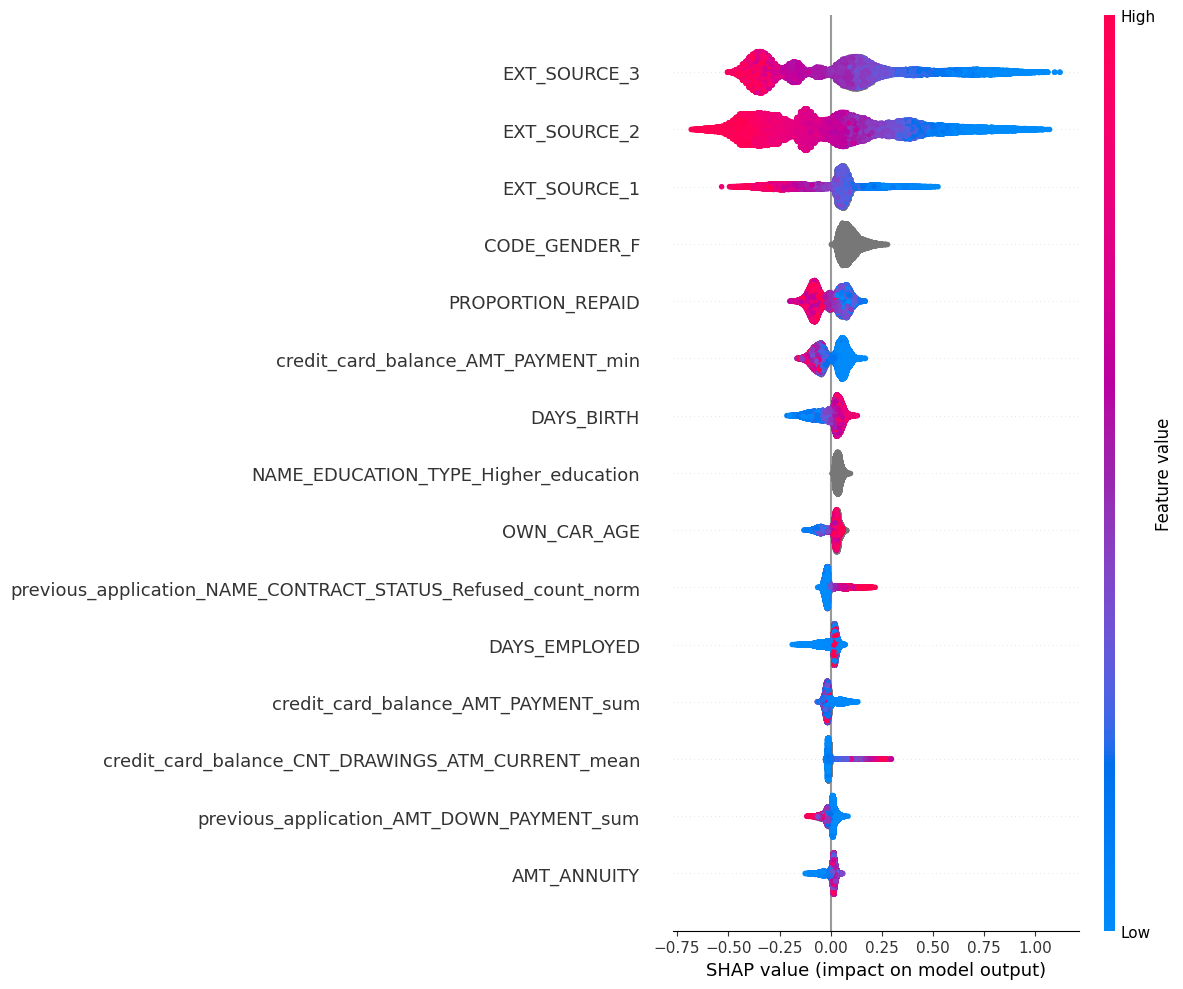

In [ ]:
shap.summary_plot (shap_values, X_test_filtered_with_non_null_importance, max_display=15, plot_size=[12,10])

In [ ]:
shap.initjs()

## Feature importance locale

In [ ]:
loaded_lgbm_model

LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=2000,
               n_jobs=1, num_leaves=41, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1)

In [ ]:
predictions_proba = loaded_model.predict_proba(X_test_filtered_with_non_null_importance)[:, 1]

In [ ]:
predictions_proba = loaded_model.predict_proba(X_test_filtered_with_non_null_importance)[:, 1]

In [ ]:
X_test_with_preds = X_test_filtered_with_non_null_importance.copy()
X_test_with_preds['probability_default'] = predictions_proba

In [ ]:
# Sort by probability
X_test_sorted = X_test_with_preds.sort_values(by='probability_default', ascending=False)

# Select indices of instances to plot (original indices from X_test_filtered_with_non_null_importance)
num_instances_to_plot = 3 # Plot 3 highest and 3 lowest

# Get original DataFrame indices for these sorted instances
# These indices will be used with .loc on the original X_test_filtered_with_non_null_importance
# and with integer position for shap_values (since shap_values rows correspond to X_test_filtered rows)
high_prob_indices_original = X_test_sorted.head(num_instances_to_plot).index
low_prob_indices_original = X_test_sorted.tail(num_instances_to_plot).index

print(f"Indices of top {num_instances_to_plot} high probability instances: {high_prob_indices_original.tolist()}")
print(f"Probabilities: {X_test_sorted.head(num_instances_to_plot)['probability_default'].tolist()}")
print(f"Indices of top {num_instances_to_plot} low probability instances: {low_prob_indices_original.tolist()}")
print(f"Probabilities: {X_test_sorted.tail(num_instances_to_plot)['probability_default'].tolist()}")


Indices of top 3 high probability instances: [22815, 47901, 25215]
Probabilities: [0.8229127653138739, 0.8199170534966596, 0.8178559275420296]
Indices of top 3 low probability instances: [6004, 18026, 28307]
Probabilities: [0.17004492466329502, 0.16636731633389099, 0.1647364094340497]


In [ ]:
max_display_waterfall = 15 # Number of top features to show in waterfall

Using scalar explainer.expected_value as base value: -0.3042953642981175

--- Generating Waterfall Plots for High Probability Instances ---

Plotting High Probability Instance 1 (Original Index: 22815, Position: 22815)
Predicted Probability of Default: 0.8229


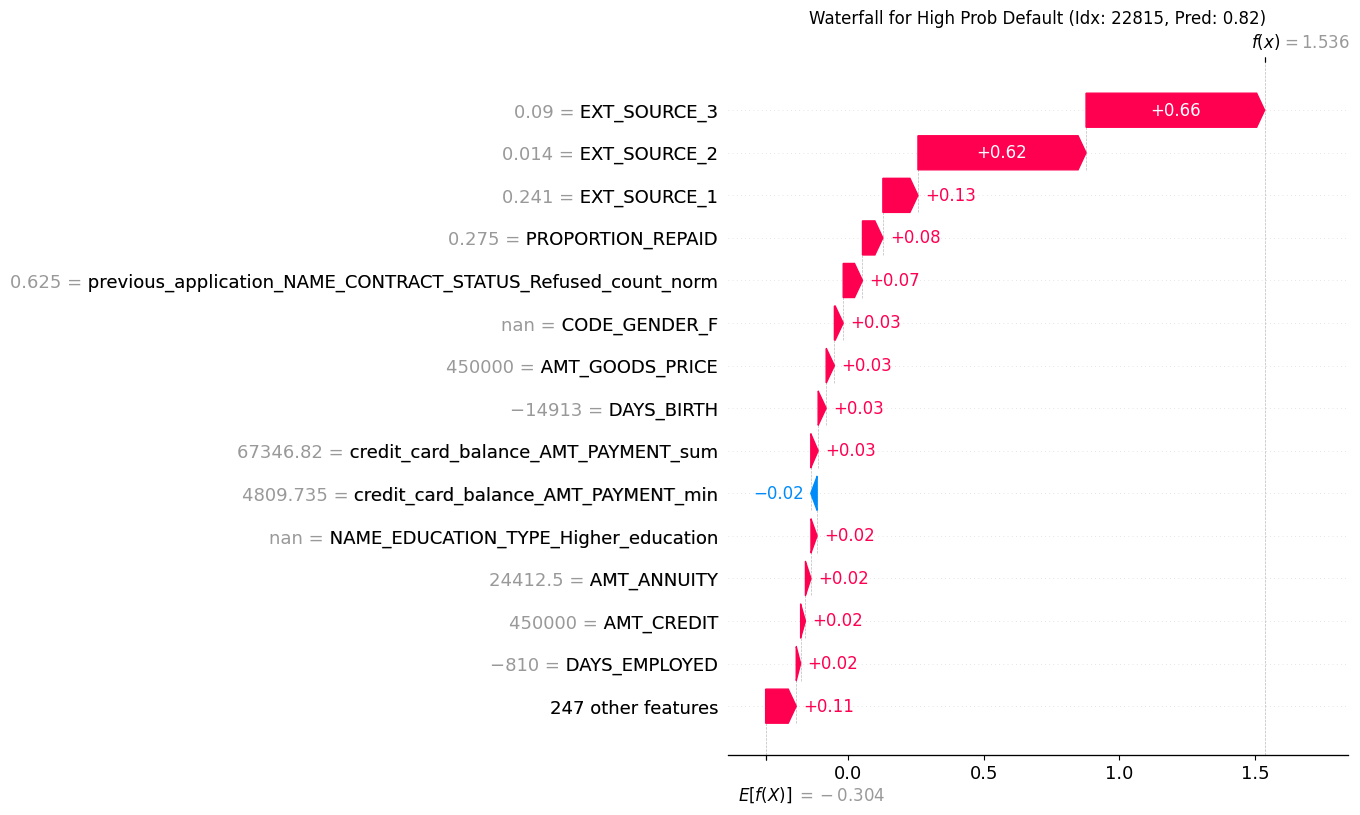


Plotting High Probability Instance 2 (Original Index: 47901, Position: 47901)
Predicted Probability of Default: 0.8199


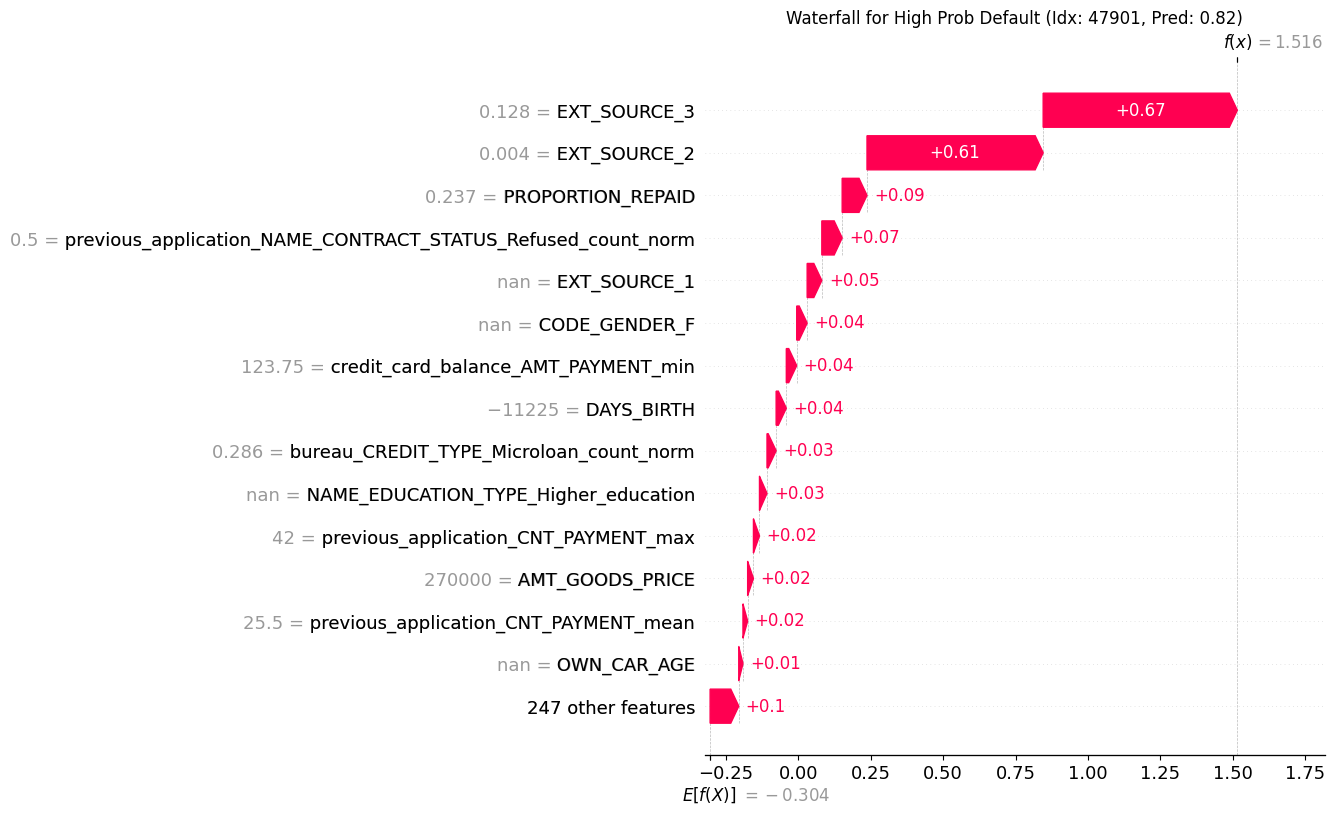


Plotting High Probability Instance 3 (Original Index: 25215, Position: 25215)
Predicted Probability of Default: 0.8179


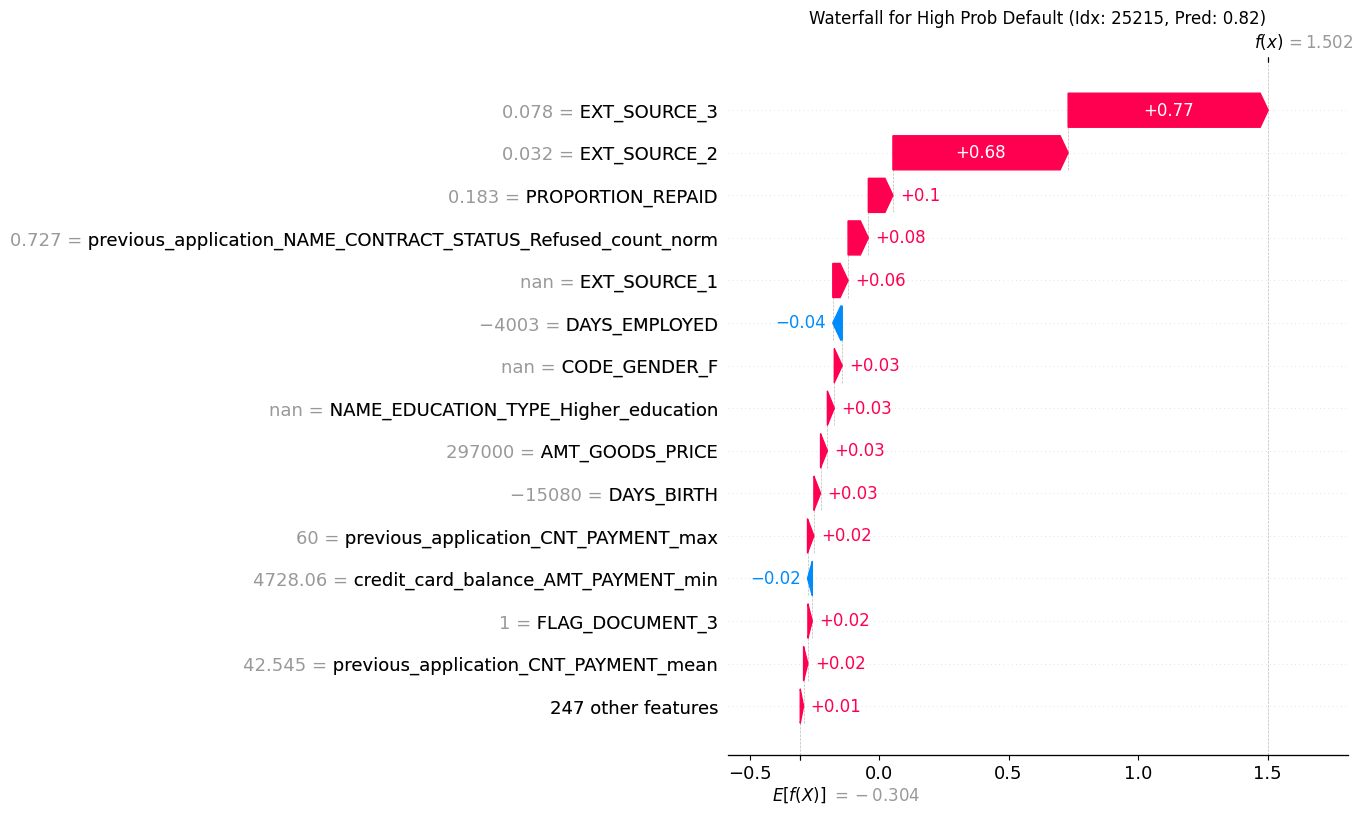


--- Generating Waterfall Plots for Low Probability Instances ---

Plotting Low Probability Instance 1 (Original Index: 6004, Position: 6004)
Predicted Probability of Default: 0.1700


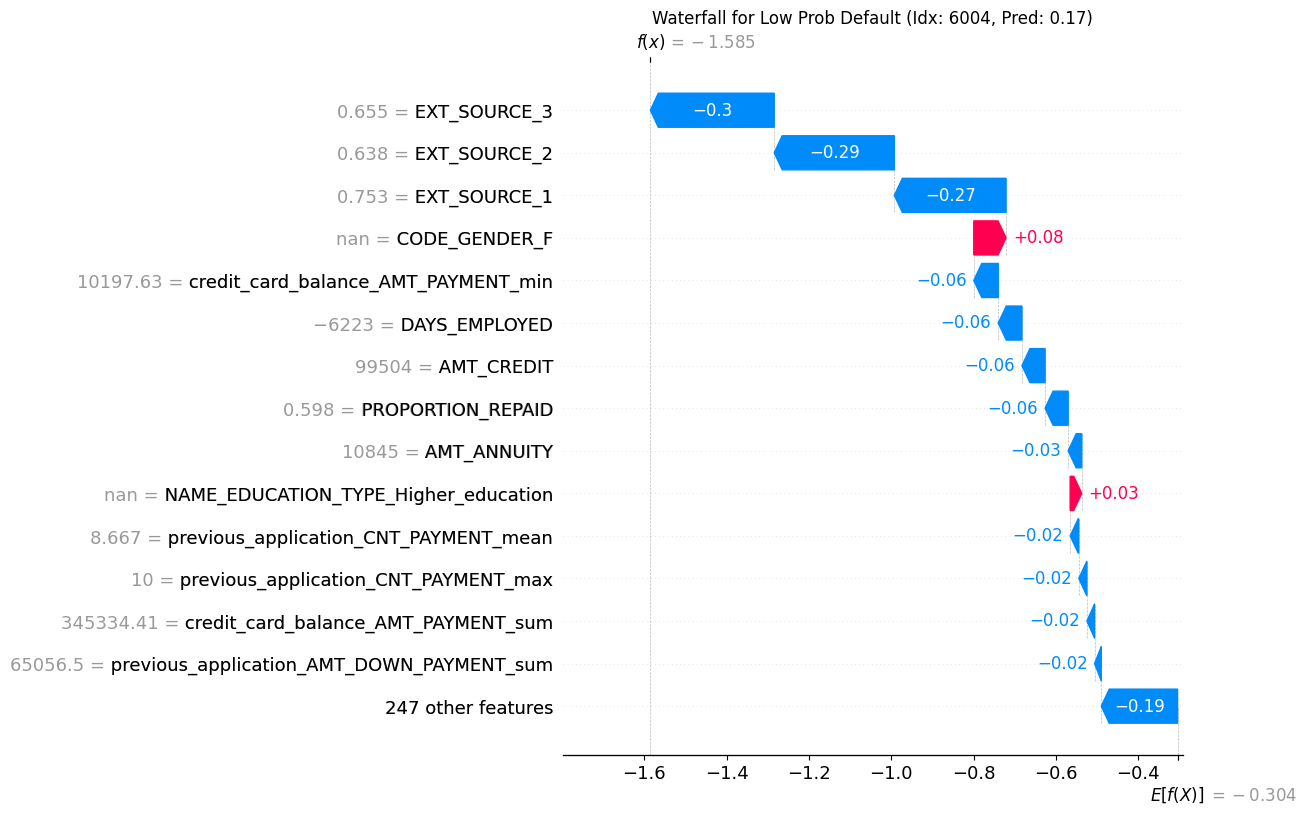


Plotting Low Probability Instance 2 (Original Index: 18026, Position: 18026)
Predicted Probability of Default: 0.1664


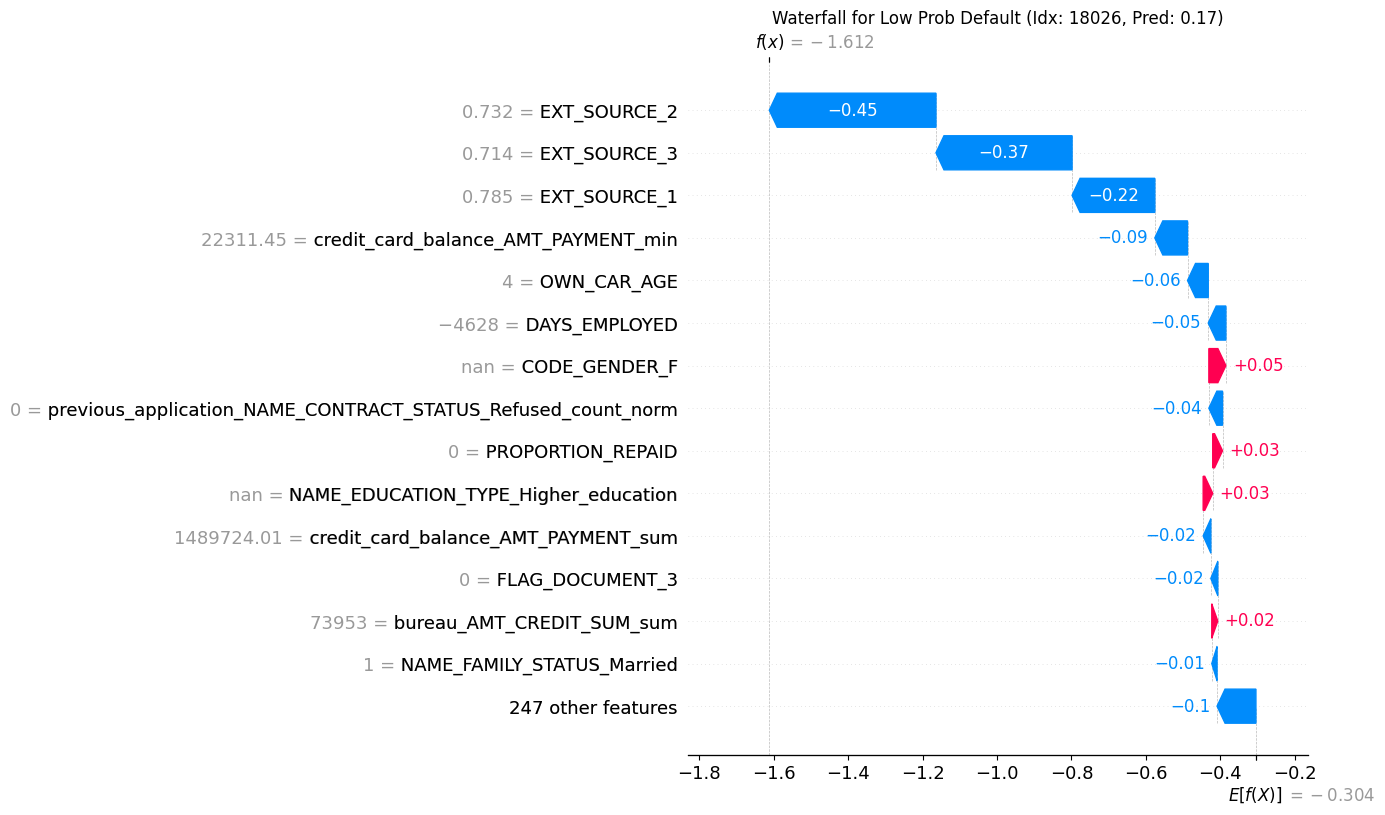


Plotting Low Probability Instance 3 (Original Index: 28307, Position: 28307)
Predicted Probability of Default: 0.1647


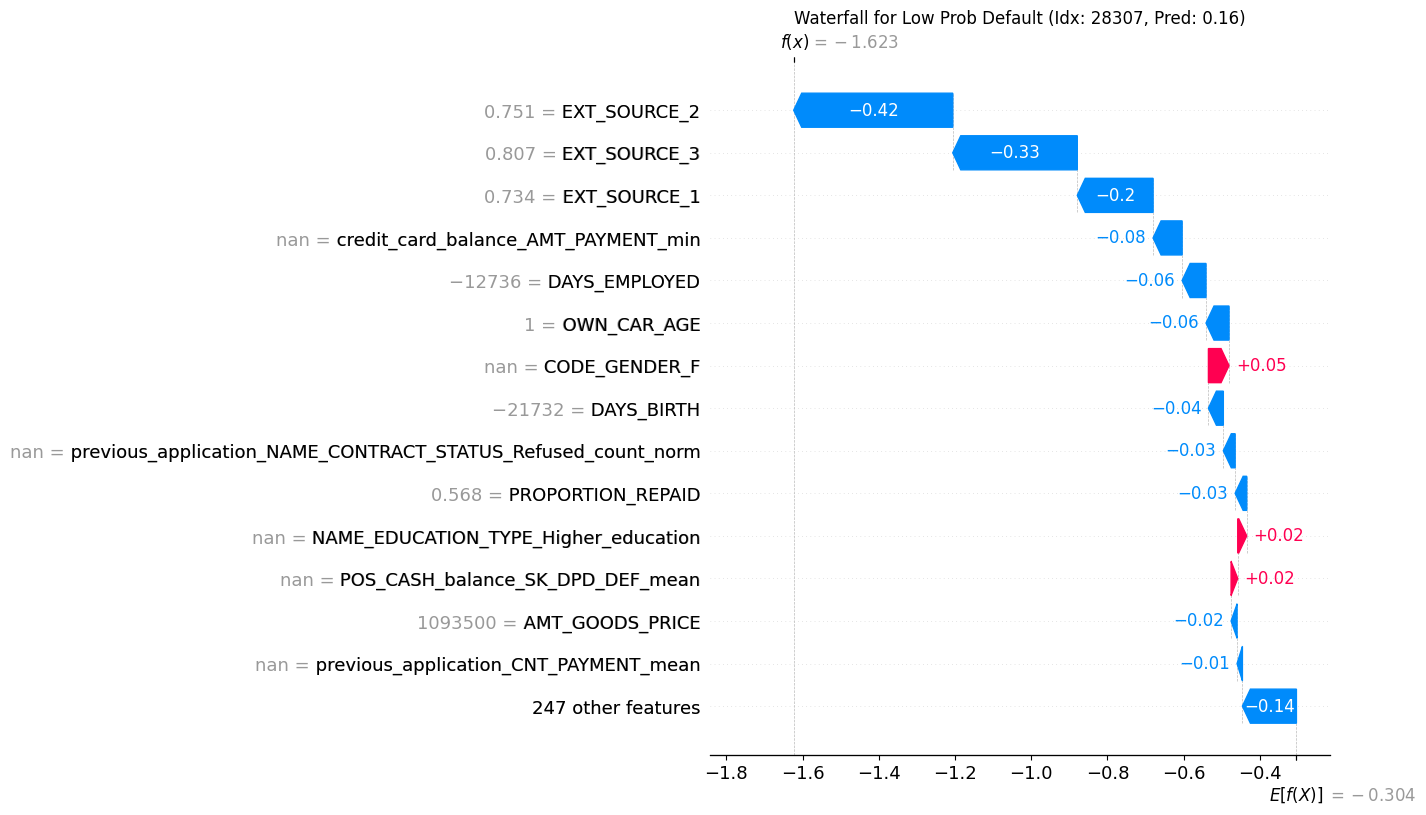


Waterfall plot generation complete.


In [ ]:
# --- Step 3: Get the Base Value (Expected Value) ---
# This is crucial. Check the structure of explainer.expected_value
# Given your shap_values.shape is (n_samples, n_features), expected_value is likely:
#   - A scalar (if SHAP decided it's a single output problem for this explanation)
#   - A list/array with one element: [expected_value_for_class_1]
#   - A list/array with two elements: [expected_value_for_class_0, expected_value_for_class_1]
#     (even if shap_values was simplified, expected_value might retain the two-class structure from the explainer's internal model understanding)

if isinstance(explainer.expected_value, (list, np.ndarray)):
    if len(explainer.expected_value) == 2: # Common for binary classifiers
        base_value = explainer.expected_value[1] # Assuming class 1 is your target (default)
        print(f"Using explainer.expected_value[1] as base value: {base_value}")
    elif len(explainer.expected_value) == 1:
         base_value = explainer.expected_value[0]
         print(f"Using explainer.expected_value[0] as base value: {base_value}")
    else: # Should not happen if it's a list/array from explainer
        base_value = explainer.expected_value
        print(f"Warning: explainer.expected_value is a list/array of unexpected length. Using as is: {base_value}")

else: # Scalar
    base_value = explainer.expected_value
    print(f"Using scalar explainer.expected_value as base value: {base_value}")

# --- Step 4: Generate Waterfall Plots ---
max_display_waterfall = 15 # Number of top features to show in waterfall

print("\n--- Generating Waterfall Plots for High Probability Instances ---")
for i, original_idx in enumerate(high_prob_indices_original):
    # Get the integer position of this original_idx in X_test_filtered_with_non_null_importance
    # This is needed to correctly index into the shap_values array
    instance_position = X_test_filtered_with_non_null_importance.index.get_loc(original_idx)

    print(f"\nPlotting High Probability Instance {i+1} (Original Index: {original_idx}, Position: {instance_position})")
    print(f"Predicted Probability of Default: {X_test_with_preds.loc[original_idx, 'probability_default']:.4f}")

    # Create a SHAP Explanation object for the specific instance
    explanation_object = shap.Explanation(
        values=shap_values[instance_position, :],  # SHAP values for this instance
        base_values=base_value,                    # Base value (expected prediction)
        data=X_test_filtered_with_non_null_importance.loc[original_idx].values, # Raw feature values for this instance
        feature_names=X_test_filtered_with_non_null_importance.columns.tolist()
    )

    shap.plots.waterfall(explanation_object, max_display=max_display_waterfall, show=False)
    # For older SHAP versions, the syntax was slightly different:
    # shap.waterfall_plot(base_value,
    #                     shap_values[instance_position, :],
    #                     features=X_test_filtered_with_non_null_importance.loc[original_idx].values,
    #                     feature_names=X_test_filtered_with_non_null_importance.columns.tolist(),
    #                     max_display=max_display_waterfall,
    #                     show=True)
    plt.title(f"Waterfall for High Prob Default (Idx: {original_idx}, Pred: {X_test_with_preds.loc[original_idx, 'probability_default']:.2f})")
    plt.show()


print("\n--- Generating Waterfall Plots for Low Probability Instances ---")
for i, original_idx in enumerate(low_prob_indices_original):
    instance_position = X_test_filtered_with_non_null_importance.index.get_loc(original_idx)

    print(f"\nPlotting Low Probability Instance {i+1} (Original Index: {original_idx}, Position: {instance_position})")
    print(f"Predicted Probability of Default: {X_test_with_preds.loc[original_idx, 'probability_default']:.4f}")

    explanation_object = shap.Explanation(
        values=shap_values[instance_position, :],
        base_values=base_value,
        data=X_test_filtered_with_non_null_importance.loc[original_idx].values,
        feature_names=X_test_filtered_with_non_null_importance.columns.tolist()
    )

    shap.plots.waterfall(explanation_object, max_display=max_display_waterfall, show=False)
    plt.title(f"Waterfall for Low Prob Default (Idx: {original_idx}, Pred: {X_test_with_preds.loc[original_idx, 'probability_default']:.2f})")
    plt.show()

print("\nWaterfall plot generation complete.")